<a href="https://colab.research.google.com/github/yakaralar/IE492/blob/master/Decision_Trees_LGB_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
import glob
import shutil
os.listdir()

['.config',
 'RealTimeConsumption-01122014-09032020.csv',
 'updated_support-date_based_information.r',
 'RealTimeConsumption_unholidayized.csv',
 'drive',
 'RealTimeConsumption_holiday.csv',
 'sample_data']

In [0]:
os.listdir("drive/My Drive/colab_datas/IE 492")

['Comparison of methods.pdf',
 '1-s2.0-S1364032114000914-main.pdf',
 '1-s2.0-S0360544209002539-main.pdf',
 '1-s2.0-S1876610211043116-main.pdf',
 '1-s2.0-S0305048311001423-main.pdf',
 'weather_turkey_processed.zip',
 'Meta_L_makaleler',
 'all_data.feather',
 'UECM-15012015-20022020.csv',
 'RealTimeConsumption-01122014-09032020.csv',
 'updated_support-date_based_information.r',
 'ozel_gunler',
 'RealTimeConsumption_unholidayized.csv',
 'RealTimeConsumption_unhol_decomposed.csv',
 'RealTimeConsumption_holiday.csv',
 'HW_preds.csv',
 'kubi_preds',
 'HW_preds_new.csv',
 'arima_preds.csv',
 'arima_preds_datetime.csv']

In [0]:
shutil.copy("drive/My Drive/colab_datas/IE 492/RealTimeConsumption_unholidayized.csv","./")
shutil.copy("drive/My Drive/colab_datas/IE 492/updated_support-date_based_information.r","./")
shutil.copy("drive/My Drive/colab_datas/IE 492/RealTimeConsumption-01122014-09032020.csv","./")
shutil.copy("drive/My Drive/colab_datas/IE 492/RealTimeConsumption_holiday.csv","./")

'./RealTimeConsumption_holiday.csv'

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
%matplotlib inline
from tqdm import tqdm_notebook as tqdm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Evaluation function

In [0]:
!pip install graphviz
!pip install sklearn --upgrade
from sklearn.metrics import mean_squared_error,mean_squared_log_error,mean_absolute_error
from sklearn.tree import DecisionTreeRegressor,plot_tree

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

eval_df=[]
def eval_function(name_,y_true, y_pred,valid_df):
    """
    docstring denir buraya func paramlarının neler oldugunu yazarsınız
    name_:kullanılan modelin ismi
    y_true:actual values
    y_pred:predicted values
    valid_df:modele verdiginiz sekliyle validation dataframe'i ve yanına datetime'ı
    """
    rmse_=np.sqrt(mean_squared_error(y_true,y_pred))
    rmsle_=np.sqrt(mean_squared_log_error(y_true,y_pred))
    mae_=mean_absolute_error(y_true,y_pred)
    mape_=mean_absolute_percentage_error(y_true, y_pred)

    print("RMSE: ",rmse_)
    print("RMSLE: ",rmsle_)
    print("MAE: ",mae_)
    print("MAPE: ",mape_)
    plt.figure(figsize=(16,10))
    sns.scatterplot(x=y_pred,y=y_true)
    plt.pause(0.01)
    plt.figure(figsize=(16,10))
    sns.residplot(y_true,y_pred)
    plt.pause(0.01)
    nchunks=6 # plot count
    fig,ax=plt.subplots(nrows=nchunks,figsize=(32,25))
    valid_copy=valid_df.reset_index(drop=True).copy()
    for i,datetime_ in enumerate(np.array_split(valid_copy["Datetime"],nchunks)):
        sns.lineplot(y=y_true[datetime_.index.tolist()],x=datetime_,color="green",ax=ax[i])
        sns.lineplot(y=y_pred[datetime_.index.tolist()],x=datetime_,color="red",ax=ax[i])
    plt.pause(0.01)
    res_model=DecisionTreeRegressor(max_depth=4)
    _, ax = plt.subplots(figsize=(60, 60))  # whatever size you want
    fig=res_model.fit(valid_df.drop(columns=["Datetime"]),y_true-y_pred)
    plot_tree(fig,ax=ax,feature_names=valid_df.drop(columns=["Datetime"]).columns,fontsize=16)
    plt.pause(0.01)
    ## saatlik mape tanımla
    return name_, rmse_,rmsle_,mae_,mape_

Requirement already up-to-date: sklearn in /usr/local/lib/python3.6/dist-packages (0.0)


# Consumption df

In [0]:
# bruuuuuuuh
cons_unholidayized=pd.read_csv("RealTimeConsumption_unholidayized.csv",encoding='latin-1')
cons_unholidayized.columns=["Date","Hour","Consumption"]+cons_unholidayized.columns.tolist()[3:]
cons_unholidayized["Datetime"]=cons_unholidayized["Date"]+" "+cons_unholidayized["Hour"]
cons_unholidayized["Datetime"]=pd.to_datetime(cons_unholidayized["Datetime"],format="%d.%m.%Y %H:%M")
cons_unholidayized.head(5)

Date   Hour  ...  is_yilbasioncesi is_zaferbayrami
0  31.12.2015  00:00  ...         38.254867             0.0
1  31.12.2015  01:00  ...         38.254867             0.0
2  31.12.2015  02:00  ...         38.254867             0.0
3  31.12.2015  03:00  ...         38.254867             0.0
4  31.12.2015  04:00  ...         38.254867             0.0

[5 rows x 43 columns]

In [0]:
# bruuuuuuuh
cons_holiday_binary=pd.read_csv("RealTimeConsumption_holiday.csv",encoding='latin-1')
cons_holiday_binary["Datetime"]=cons_holiday_binary["Date"]+" "+cons_holiday_binary["Hour"]
cons_holiday_binary["Datetime"]=pd.to_datetime(cons_holiday_binary["Datetime"],format="%d.%m.%Y %H:%M")
cons_holiday_binary.head()

Date   Hour  ...  is_yilbasioncesi is_zaferbayrami
0  31.12.2015  00:00  ...                 1               0
1  31.12.2015  01:00  ...                 1               0
2  31.12.2015  02:00  ...                 1               0
3  31.12.2015  03:00  ...                 1               0
4  31.12.2015  04:00  ...                 1               0

[5 rows x 43 columns]

# Modelling

## CatBoost

In [0]:
## iki gün oncenin butun datasını alıcam 24 saatin yani
cat_df_1=cons_holiday_binary.copy()
cat_df_1["Hour"]=cat_df_1["Hour"].apply(lambda x:x.split(":")[0]).astype(int)
cat_df_1["Day"]=cat_df_1["Date"].apply(lambda x:x.split(".")[0]).astype(int)
cat_df_1["Month"]=cat_df_1["Date"].apply(lambda x:x.split(".")[1]).astype(int)
cat_df_1["weekday"]=pd.to_datetime(cat_df_1["Date"]).apply(lambda x: x.weekday()).astype(int)

# hour lagging
for hour in range(24):
    cat_df_1["2day_{}hour_lag".format(hour)]=cat_df_1["Consumption"].shift(24*2+hour)

# week lagging
for hour in range(24):
    cat_df_1["week_{}hour_lag".format(hour)]=cat_df_1["Consumption"].shift(24*7+hour)
cat_df_1=cat_df_1.dropna()
cat_df_1.head()

Date  Hour  ...  week_22hour_lag week_23hour_lag
168  07.01.2016     0  ...         28606.05        27705.82
169  07.01.2016     1  ...         27705.82        26277.24
170  07.01.2016     2  ...         26277.24        24991.82
171  07.01.2016     3  ...         24991.82        23532.61
172  07.01.2016     4  ...         23532.61        22464.78

[5 rows x 94 columns]

In [0]:
try:
    from catboost import CatBoostRegressor
except ModuleNotFoundError:
    !pip install catboost
    from catboost import CatBoostRegressor

train_df=cat_df_1.loc[cat_df_1["Datetime"]<pd.to_datetime("2019-02-01 00:00:00")]
valid_df=cat_df_1.loc[cat_df_1["Datetime"]>=pd.to_datetime("2019-02-01 00:00:00")]

needed_colums=cat_df_1.columns.difference(["Datetime","Consumption","Date"])

model = CatBoostRegressor(learning_rate=0.05,
                             num_boost_round=2000,
                             objective="MAE",
                             early_stopping_rounds=300,
                             #task_type="GPU",
                             random_state=1337,
                             depth=12,
                             #bootstrap_type="Poisson",
                             subsample=0.95,
                             max_bin=150)

cat_features_=[col for col in cat_df_1.columns if col.startswith("is")] # + ["Day","Month","weekday","Hour"]

eval_set=[(valid_df[needed_colums],valid_df["Consumption"])]

model.fit(train_df[needed_colums],train_df["Consumption"],
          eval_set=eval_set,
          cat_features=[needed_colums.tolist().index(i) for i in cat_features_],verbose=2)

     |████████████████████████████████| 64.4MB 43kB/s 
0:	learn: 3905.9255701	test: 3795.3936073	best: 3795.3936073 (0)	total: 426ms	remaining: 14m 11s
2:	learn: 3569.3438099	test: 3462.4890588	best: 3462.4890588 (2)	total: 1.14s	remaining: 12m 39s
4:	learn: 3267.1601673	test: 3173.0285071	best: 3173.0285071 (4)	total: 1.84s	remaining: 12m 13s
6:	learn: 2987.2206063	test: 2917.5166153	best: 2917.5166153 (6)	total: 2.56s	remaining: 12m 8s
8:	learn: 2743.3043901	test: 2691.7578118	best: 2691.7578118 (8)	total: 3.31s	remaining: 12m 11s
10:	learn: 2529.2340869	test: 2494.6366938	best: 2494.6366938 (10)	total: 4.02s	remaining: 12m 6s
12:	learn: 2331.2680027	test: 2309.3637283	best: 2309.3637283 (12)	total: 4.74s	remaining: 12m 3s
14:	learn: 2158.4053925	test: 2146.1326194	best: 2146.1326194 (14)	total: 5.46s	remaining: 12m 2s
16:	learn: 1999.9130295	test: 1997.9916299	best: 1997.9916299 (16)	total: 6.18s	remaining: 12m 1s
18:	learn: 1865.2089864	test: 1874.6943784	best: 1874.6943784 (18)	to

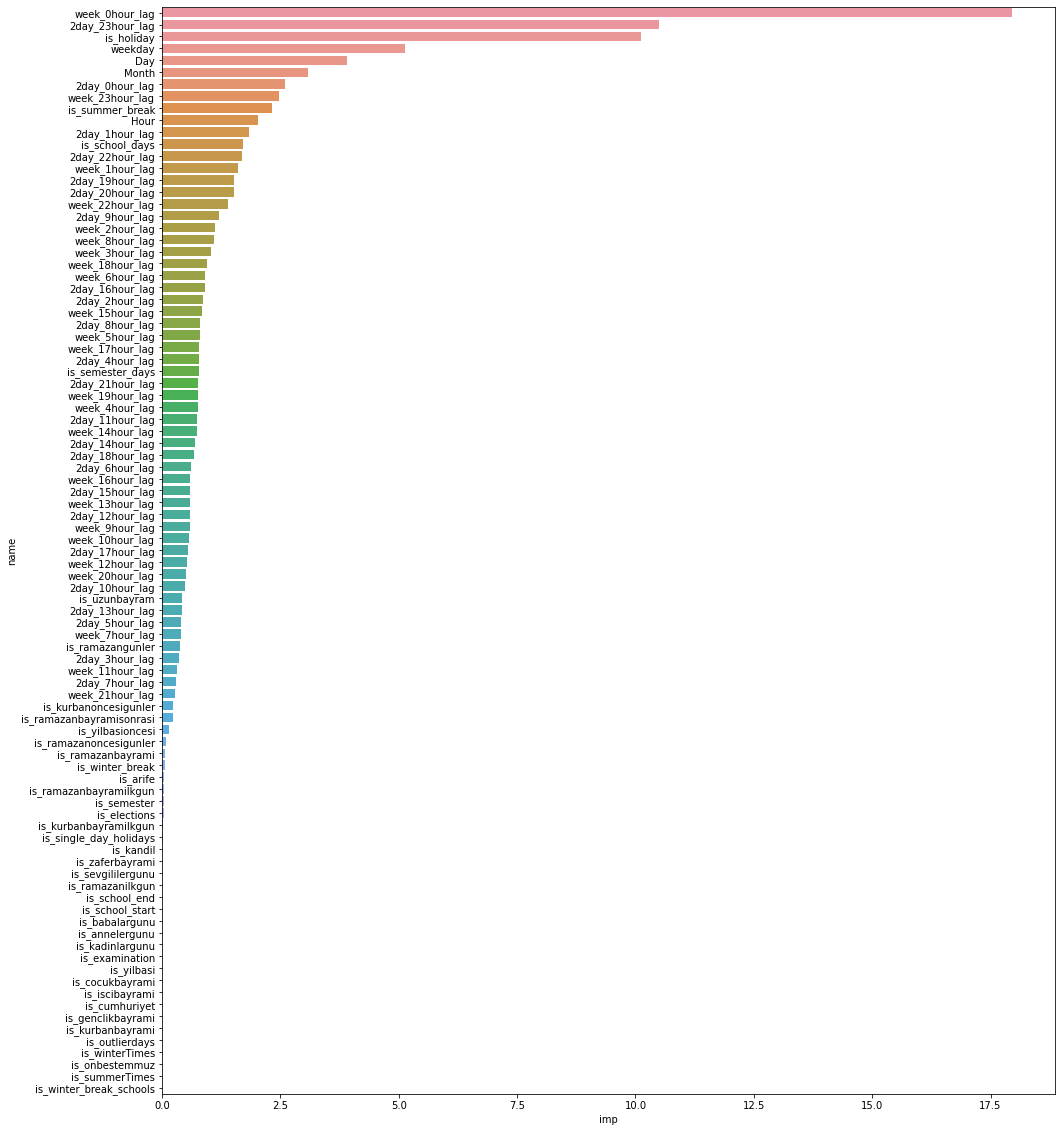

In [0]:
imp_df=pd.DataFrame()
imp_df["imp"]=model.feature_importances_
imp_df["name"]=model.feature_names_
plt.figure(figsize=(16,20))
sns.barplot(x="imp",y="name",data=imp_df.sort_values(by="imp",ascending=False))

RMSE:  1328.106444005358
RMSLE:  0.04191559449169635
MAE:  889.400135469239
MAPE:  2.706724798472254


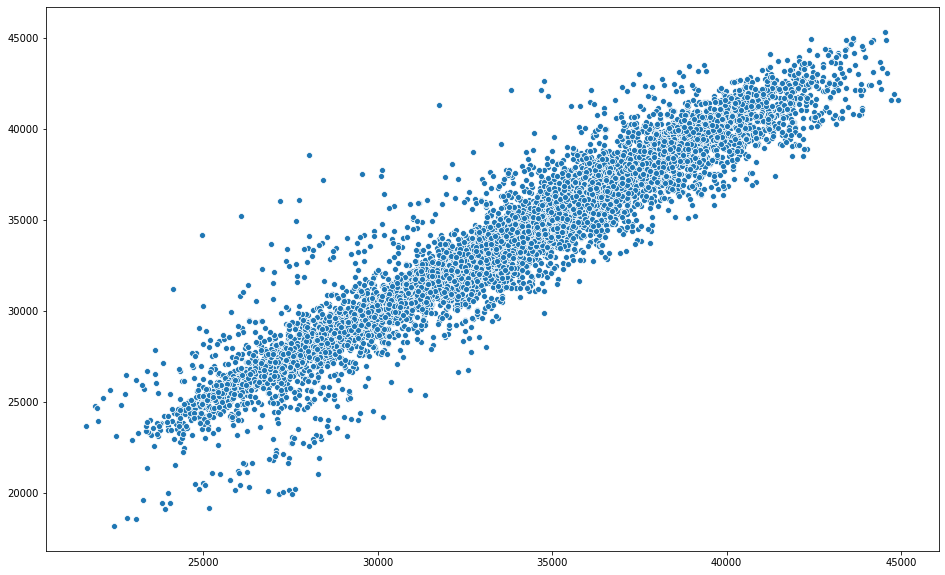

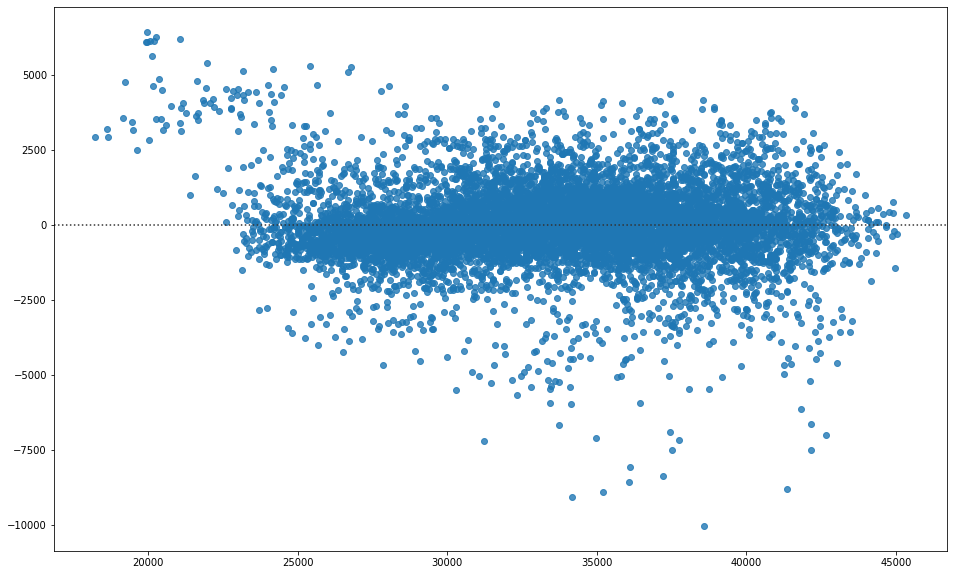

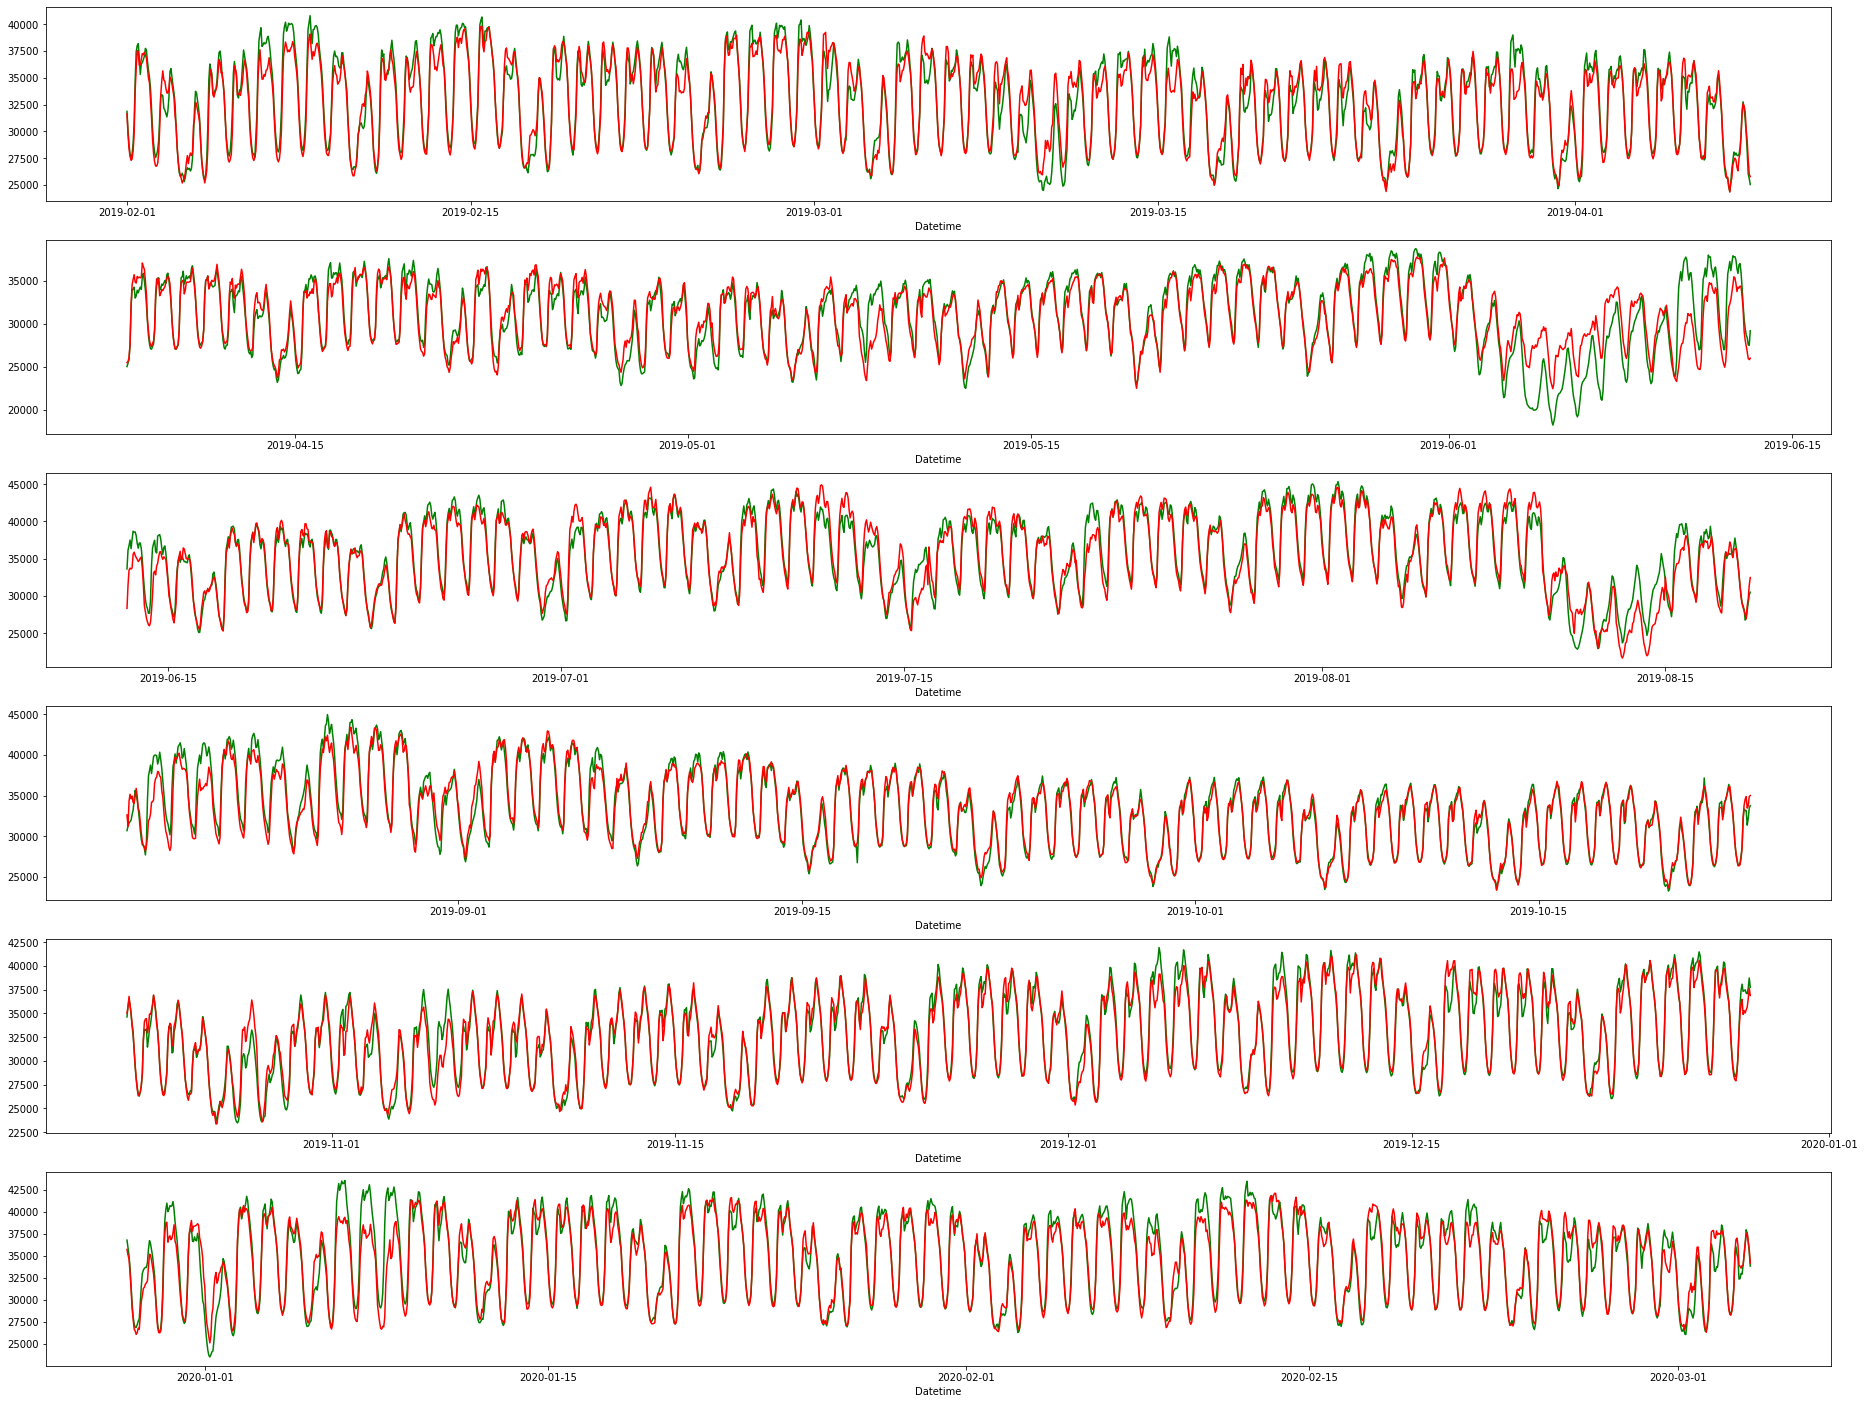

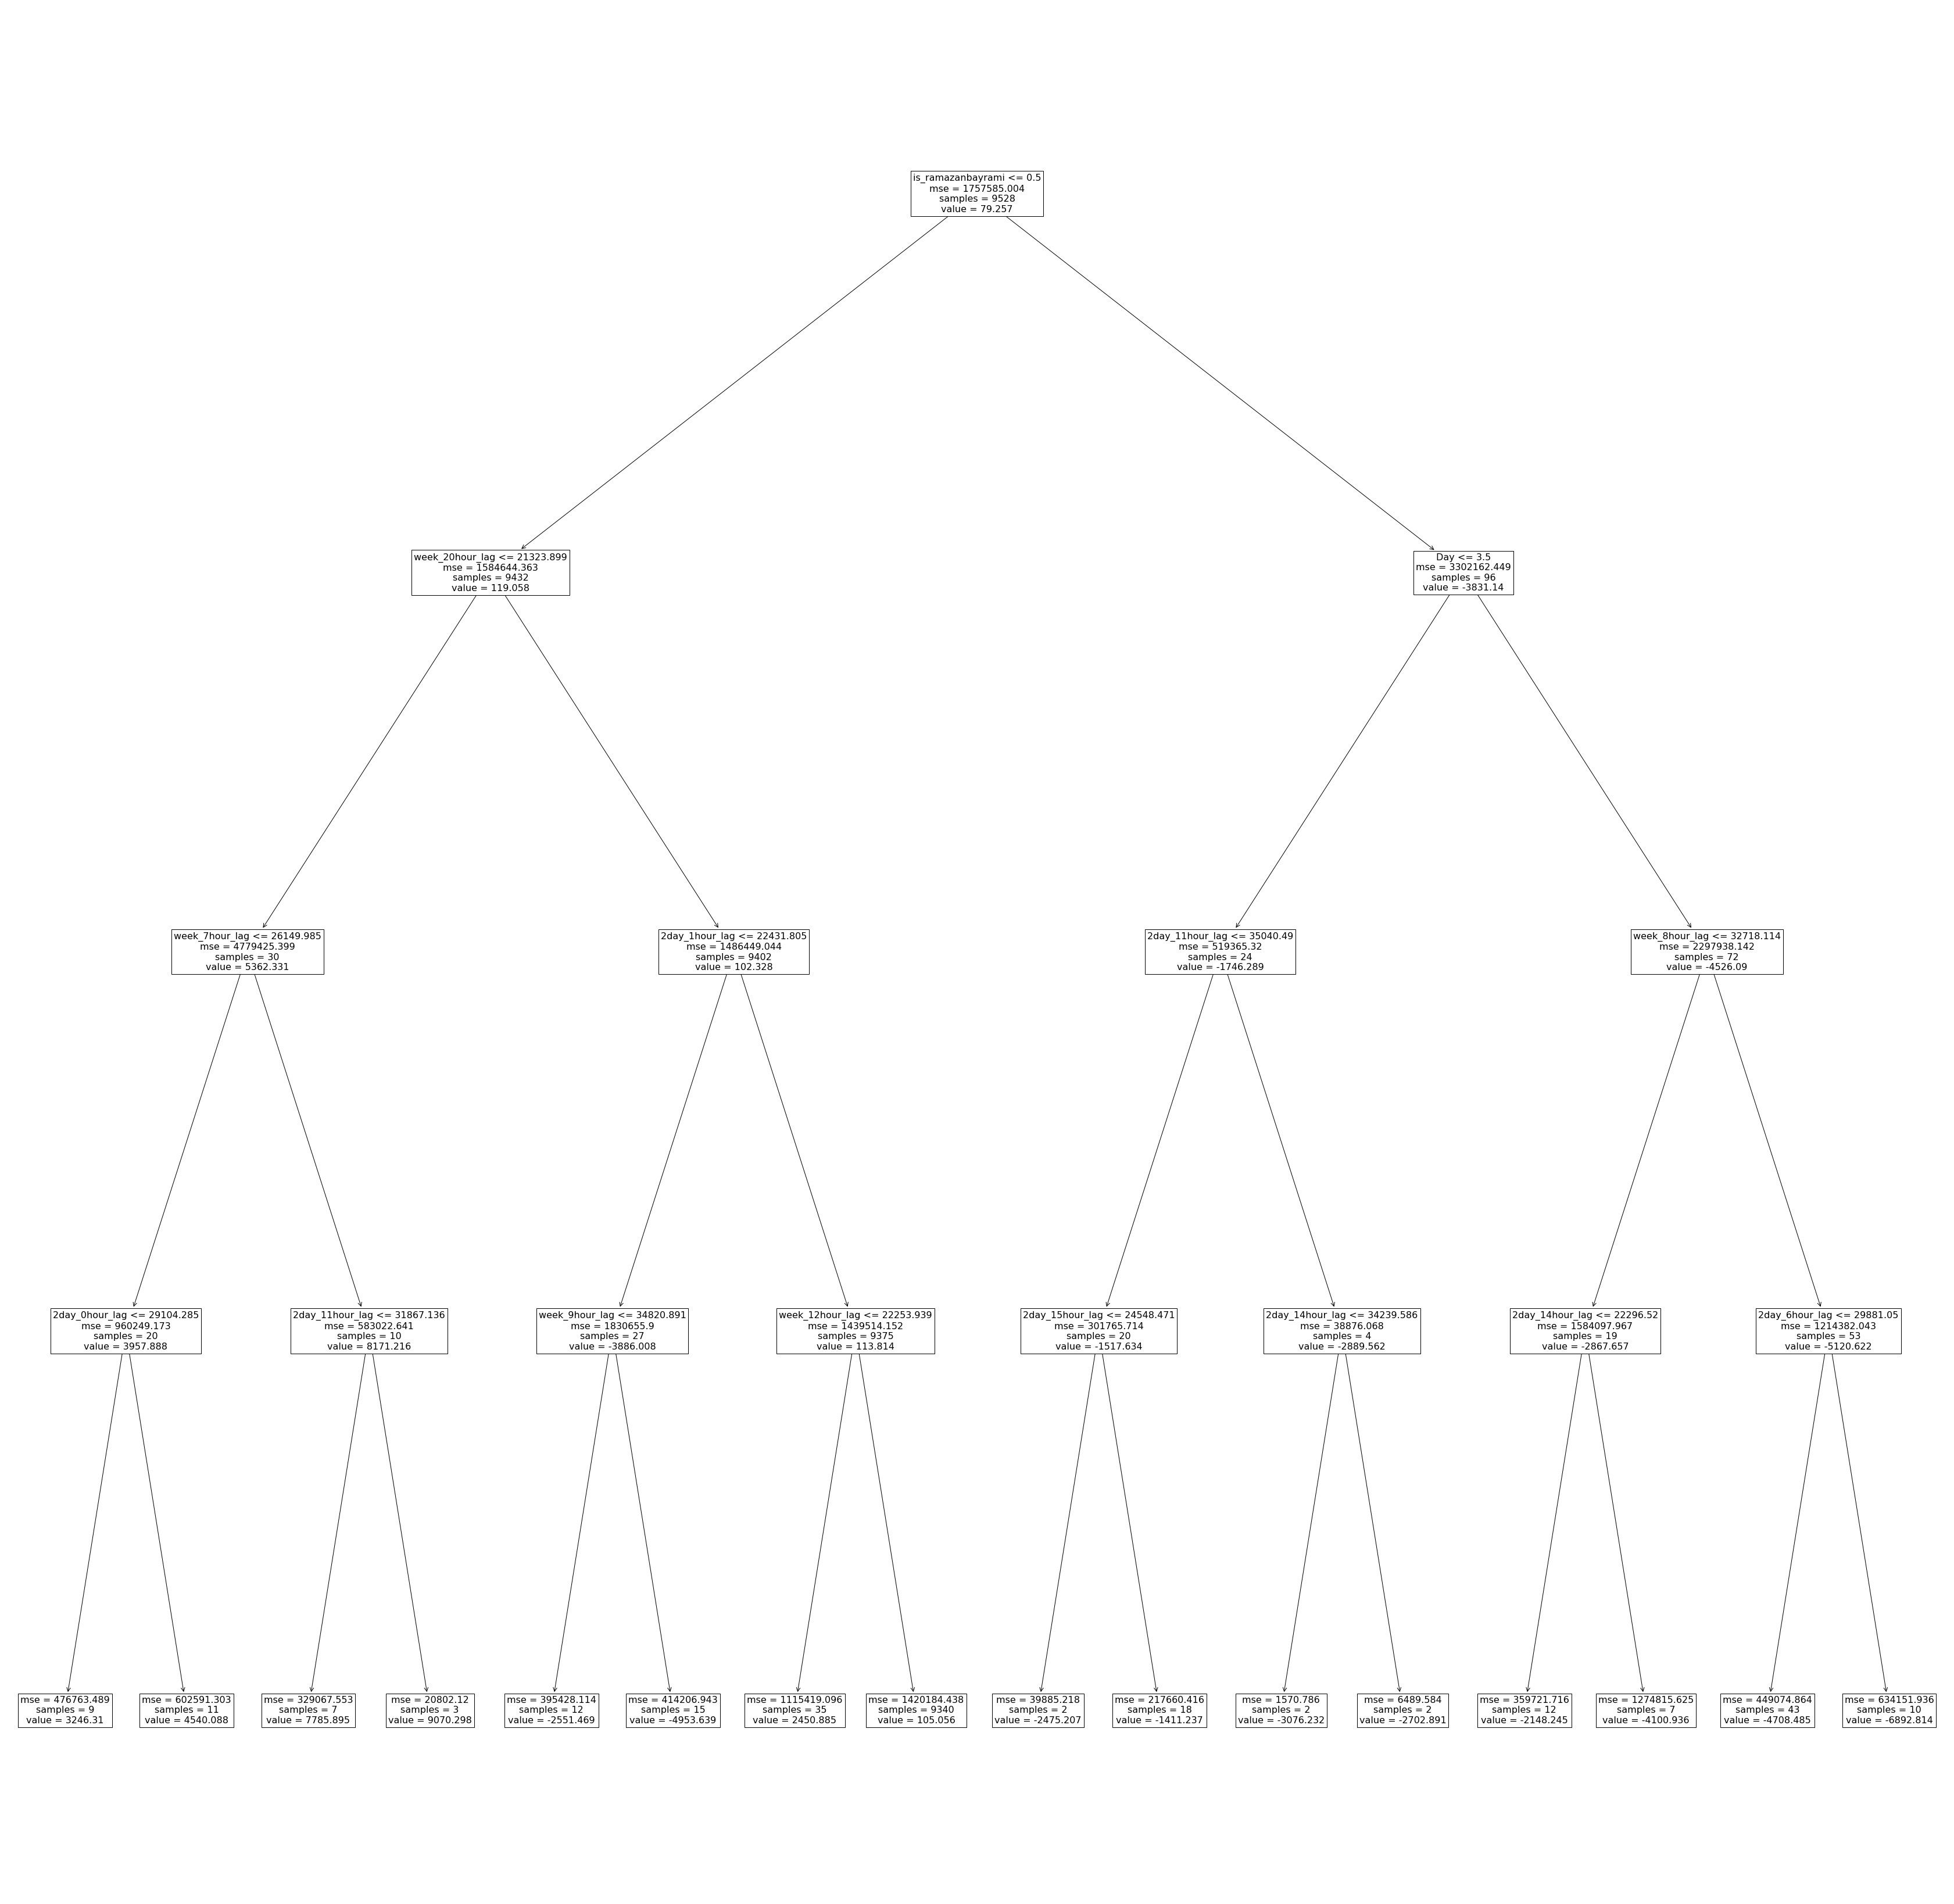

('Cat1',
 1328.106444005358,
 0.04191559449169635,
 889.400135469239,
 2.706724798472254)

In [0]:
y_pred=model.predict(valid_df[needed_colums])
y_true=valid_df["Consumption"].values
eval_function("Cat1",y_true,y_pred,valid_df[needed_colums.tolist()+["Datetime"]])

In [0]:
valid_df["Cat1"]=y_pred
valid_df[["Datetime","Cat1"]].to_csv("drive/My Drive/colab_datas/IE 492/kubi_preds/Cat1.csv",index=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## catboost time window approach

In [0]:
## iki gün oncenin butun datasını alıcam 24 saatin yani
cat_df_1=cons_holiday_binary.copy()
cat_df_1["Hour"]=cat_df_1["Hour"].apply(lambda x:x.split(":")[0]).astype(int)
cat_df_1["Day"]=cat_df_1["Date"].apply(lambda x:x.split(".")[0]).astype(int)
cat_df_1["Month"]=cat_df_1["Date"].apply(lambda x:x.split(".")[1]).astype(int)
cat_df_1["weekday"]=pd.to_datetime(cat_df_1["Date"]).apply(lambda x: x.weekday()).astype(int)

# hour lagging
for hour in range(24):
    cat_df_1["2day_{}hour_lag".format(hour)]=cat_df_1["Consumption"].shift(24*2-hour)

# week lagging
for hour in range(24):
    cat_df_1["week_{}hour_lag".format(hour)]=cat_df_1["Consumption"].shift(24*7-hour)
cat_df_1=cat_df_1.dropna()
cat_df_1.head()

Date  Hour  ...  week_22hour_lag week_23hour_lag
168  07.01.2016     0  ...         28606.05        27705.82
169  07.01.2016     1  ...         27705.82        26277.24
170  07.01.2016     2  ...         26277.24        24991.82
171  07.01.2016     3  ...         24991.82        23532.61
172  07.01.2016     4  ...         23532.61        22464.78

[5 rows x 94 columns]

In [0]:
try:
    from catboost import CatBoostRegressor
except ModuleNotFoundError:
    !pip install catboost
    from catboost import CatBoostRegressor
cat_df_1=cat_df_1.loc[cat_df_1["Datetime"]>pd.to_datetime("2019-03-03 23:00:00")]
needed_colums=cat_df_1.columns.difference(["Datetime","Consumption","Date"])
cat_features_=[col for col in cat_df_1.columns if col.startswith("is")] # + ["Day","Month","weekday","Hour"]
predictions_df={}
time_window=7*24*5 # 5 hafta time window 
pred_window=7*24
cat_df_1=cat_df_1.reset_index(drop=True)
for i in tqdm(range(time_window,len(cat_df_1)-1)):
    train_df=cat_df_1.iloc[i-time_window:i-1]
    test_df=cat_df_1.iloc[i+1:i+1+pred_window]
    model = CatBoostRegressor(learning_rate=0.05,
                                num_boost_round=100,
                                objective="MAE",
                                early_stopping_rounds=10,
                                task_type="GPU",
                                random_state=1337,
                                depth=12,
                                bootstrap_type="Poisson",
                                subsample=0.95,
                                max_bin=150)

    #eval_set=[(valid_df[needed_colums].values.tolist(),valid_df["Consumption"])]

    model.fit(train_df[needed_colums],train_df["Consumption"],
            #eval_set=eval_set,
            cat_features=[needed_colums.tolist().index(i) for i in cat_features_],
            verbose=25)
    predictions=model.predict(test_df[needed_colums])
    predictions_df[i+1,i+1+pred_window]=predictions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


0:	learn: 3217.5733015	total: 33.8ms	remaining: 3.35s
25:	learn: 3217.1555423	total: 720ms	remaining: 2.05s
50:	learn: 3216.7362932	total: 1.36s	remaining: 1.3s
75:	learn: 3216.3122765	total: 2s	remaining: 633ms
99:	learn: 3215.9061383	total: 2.68s	remaining: 0us
0:	learn: 3217.1361740	total: 29.9ms	remaining: 2.96s
25:	learn: 3216.7225864	total: 699ms	remaining: 1.99s
50:	learn: 3216.3069130	total: 1.35s	remaining: 1.29s
75:	learn: 3215.8867700	total: 2.02s	remaining: 638ms
99:	learn: 3215.4883790	total: 2.7s	remaining: 0us
0:	learn: 3216.6766985	total: 30.4ms	remaining: 3.01s
25:	learn: 3216.2514899	total: 658ms	remaining: 1.87s
50:	learn: 3215.8325387	total: 1.31s	remaining: 1.26s
75:	learn: 3215.4123957	total: 1.99s	remaining: 628ms
99:	learn: 3215.0187723	total: 2.67s	remaining: 0us
0:	learn: 3217.3942193	total: 30.6ms	remaining: 3.03s
25:	learn: 3216.9791418	total: 704ms	remaining: 2s
50:	learn: 3216.5610846	total: 1.38s	remaining: 1.33s
75:	learn: 3216.1430274	total: 2.09s	remai

In [0]:
predictions_df

NameError: ignored

## CatBoost unholidazasd


In [0]:
cons_unholidayized

Date   Hour  ...  is_yilbasioncesi is_zaferbayrami
0      31.12.2015  00:00  ...         38.254867             0.0
1      31.12.2015  01:00  ...         38.254867             0.0
2      31.12.2015  02:00  ...         38.254867             0.0
3      31.12.2015  03:00  ...         38.254867             0.0
4      31.12.2015  04:00  ...         38.254867             0.0
...           ...    ...  ...               ...             ...
36571  03.03.2020  19:00  ...          0.000000             0.0
36572  03.03.2020  20:00  ...          0.000000             0.0
36573  03.03.2020  21:00  ...          0.000000             0.0
36574  03.03.2020  22:00  ...          0.000000             0.0
36575  03.03.2020  23:00  ...          0.000000             0.0

[36576 rows x 43 columns]

In [0]:
# cat_df_1=cons_unholidayized.copy()
# cat_df_1["Hour"]=cat_df_1["Hour"].apply(lambda x:x.split(":")[0]).astype(int)
# cat_df_1["Day"]=cat_df_1["Date"].apply(lambda x:x.split(".")[0]).astype(int)
# cat_df_1["Month"]=cat_df_1["Date"].apply(lambda x:x.split(".")[1]).astype(int)
# cat_df_1["weekday"]=pd.to_datetime(cat_df_1["Date"]).apply(lambda x: x.weekday()).astype(int)
# cat_df_1["Consumption_2_lag"]=cat_df_1["Consumption"].shift(24*2)
# cat_df_1["Consumption_7_lag"]=cat_df_1["Consumption"].shift(24*7)
# cat_df_1=cat_df_1.dropna()
# cat_df_1.head()


## iki gün oncenin butun datasını alıcam 24 saatin yani
cat_df_1=cons_unholidayized.copy()
cat_df_1["Hour"]=cat_df_1["Hour"].apply(lambda x:x.split(":")[0]).astype(int)
cat_df_1["Day"]=cat_df_1["Date"].apply(lambda x:x.split(".")[0]).astype(int)
cat_df_1["Month"]=cat_df_1["Date"].apply(lambda x:x.split(".")[1]).astype(int)
cat_df_1["weekday"]=pd.to_datetime(cat_df_1["Date"]).apply(lambda x: x.weekday()).astype(int)

# hour lagging
for hour in range(24):
    cat_df_1["2day_{}hour_lag".format(hour)]=cat_df_1["Consumption"].shift(24*2+hour)

# week lagging
for hour in range(24):
    cat_df_1["week_{}hour_lag".format(hour)]=cat_df_1["Consumption"].shift(24*7+hour)
cat_df_1=cat_df_1.dropna()
cat_df_1.head()

Date  Hour  ...  week_22hour_lag week_23hour_lag
168  07.01.2016     0  ...     28761.052083    27860.822083
169  07.01.2016     1  ...     27860.822083    32042.050266
170  07.01.2016     2  ...     32042.050266    30756.630266
171  07.01.2016     3  ...     30756.630266    29297.420266
172  07.01.2016     4  ...     29297.420266    28229.590266

[5 rows x 94 columns]

In [0]:
try:
    from catboost import CatBoostRegressor
except ModuleNotFoundError:
    !pip install catboost
    from catboost import CatBoostRegressor

train_df=cat_df_1.loc[cat_df_1["Datetime"]<pd.to_datetime("2019-02-01 00:00:00")]
valid_df=cat_df_1.loc[cat_df_1["Datetime"]>=pd.to_datetime("2019-02-01 00:00:00")]

needed_colums=cat_df_1.columns.difference(["Datetime","Consumption","Date"]+[col for col in cat_df_1.columns if col.startswith("is")])

model = CatBoostRegressor(learning_rate=0.05,
                             num_boost_round=2000,
                             objective="MAE",
                             early_stopping_rounds=300,
                             #task_type="GPU",
                             random_state=1337,
                             depth=12,
                             #bootstrap_type="Poisson",
                             subsample=0.95,
                             max_bin=150)

cat_features_= ["Day","Month","weekday","Hour"]

eval_set=[(valid_df[needed_colums],valid_df["Consumption"])]

model.fit(train_df[needed_colums],train_df["Consumption"],
          eval_set=eval_set,
          cat_features=[needed_colums.tolist().index(i) for i in cat_features_],verbose=2)

0:	learn: 3709.8501253	test: 3653.8775557	best: 3653.8775557 (0)	total: 407ms	remaining: 13m 33s
2:	learn: 3390.9196453	test: 3339.7440743	best: 3339.7440743 (2)	total: 1.22s	remaining: 13m 30s
4:	learn: 3100.7886197	test: 3048.7213541	best: 3048.7213541 (4)	total: 2.01s	remaining: 13m 22s
6:	learn: 2848.8098547	test: 2803.9510912	best: 2803.9510912 (6)	total: 2.81s	remaining: 13m 20s
8:	learn: 2619.8722462	test: 2585.1543896	best: 2585.1543896 (8)	total: 3.62s	remaining: 13m 21s
10:	learn: 2417.5936655	test: 2390.5502441	best: 2390.5502441 (10)	total: 4.44s	remaining: 13m 23s
12:	learn: 2239.1981515	test: 2217.3326732	best: 2217.3326732 (12)	total: 5.02s	remaining: 12m 47s
14:	learn: 2075.8540233	test: 2059.3392342	best: 2059.3392342 (14)	total: 5.83s	remaining: 12m 51s
16:	learn: 1933.8766309	test: 1923.3360608	best: 1923.3360608 (16)	total: 6.63s	remaining: 12m 53s
18:	learn: 1806.9945012	test: 1809.5748238	best: 1809.5748238 (18)	total: 7.43s	remaining: 12m 54s
20:	learn: 1689.8345

RMSE:  1333.8810326739833
RMSLE:  0.0403666487875099
MAE:  927.0124661267636
MAPE:  2.771364092909177


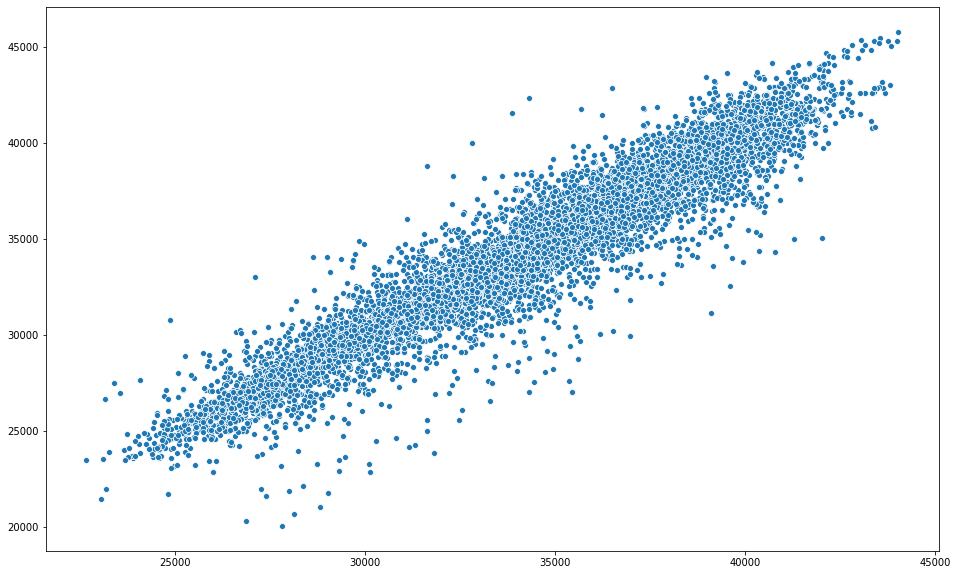

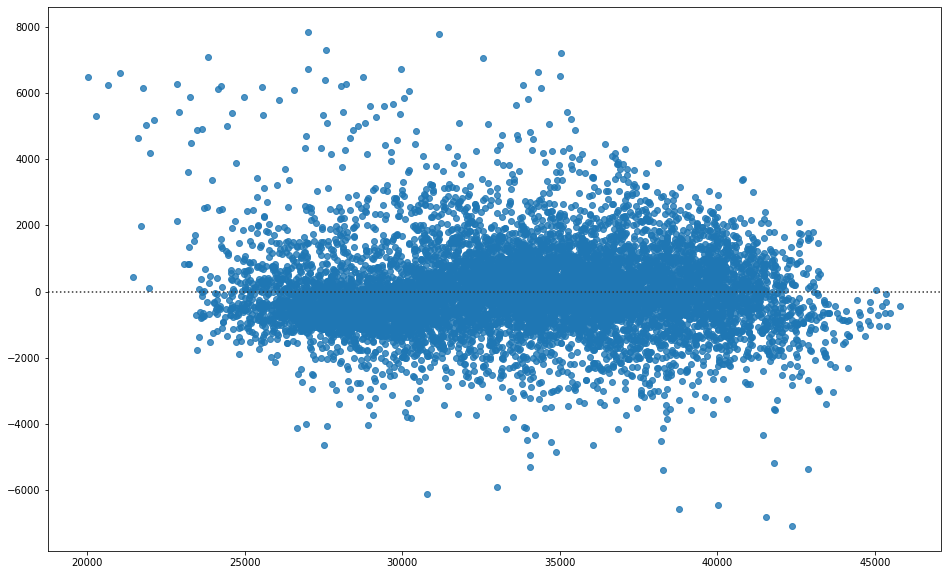

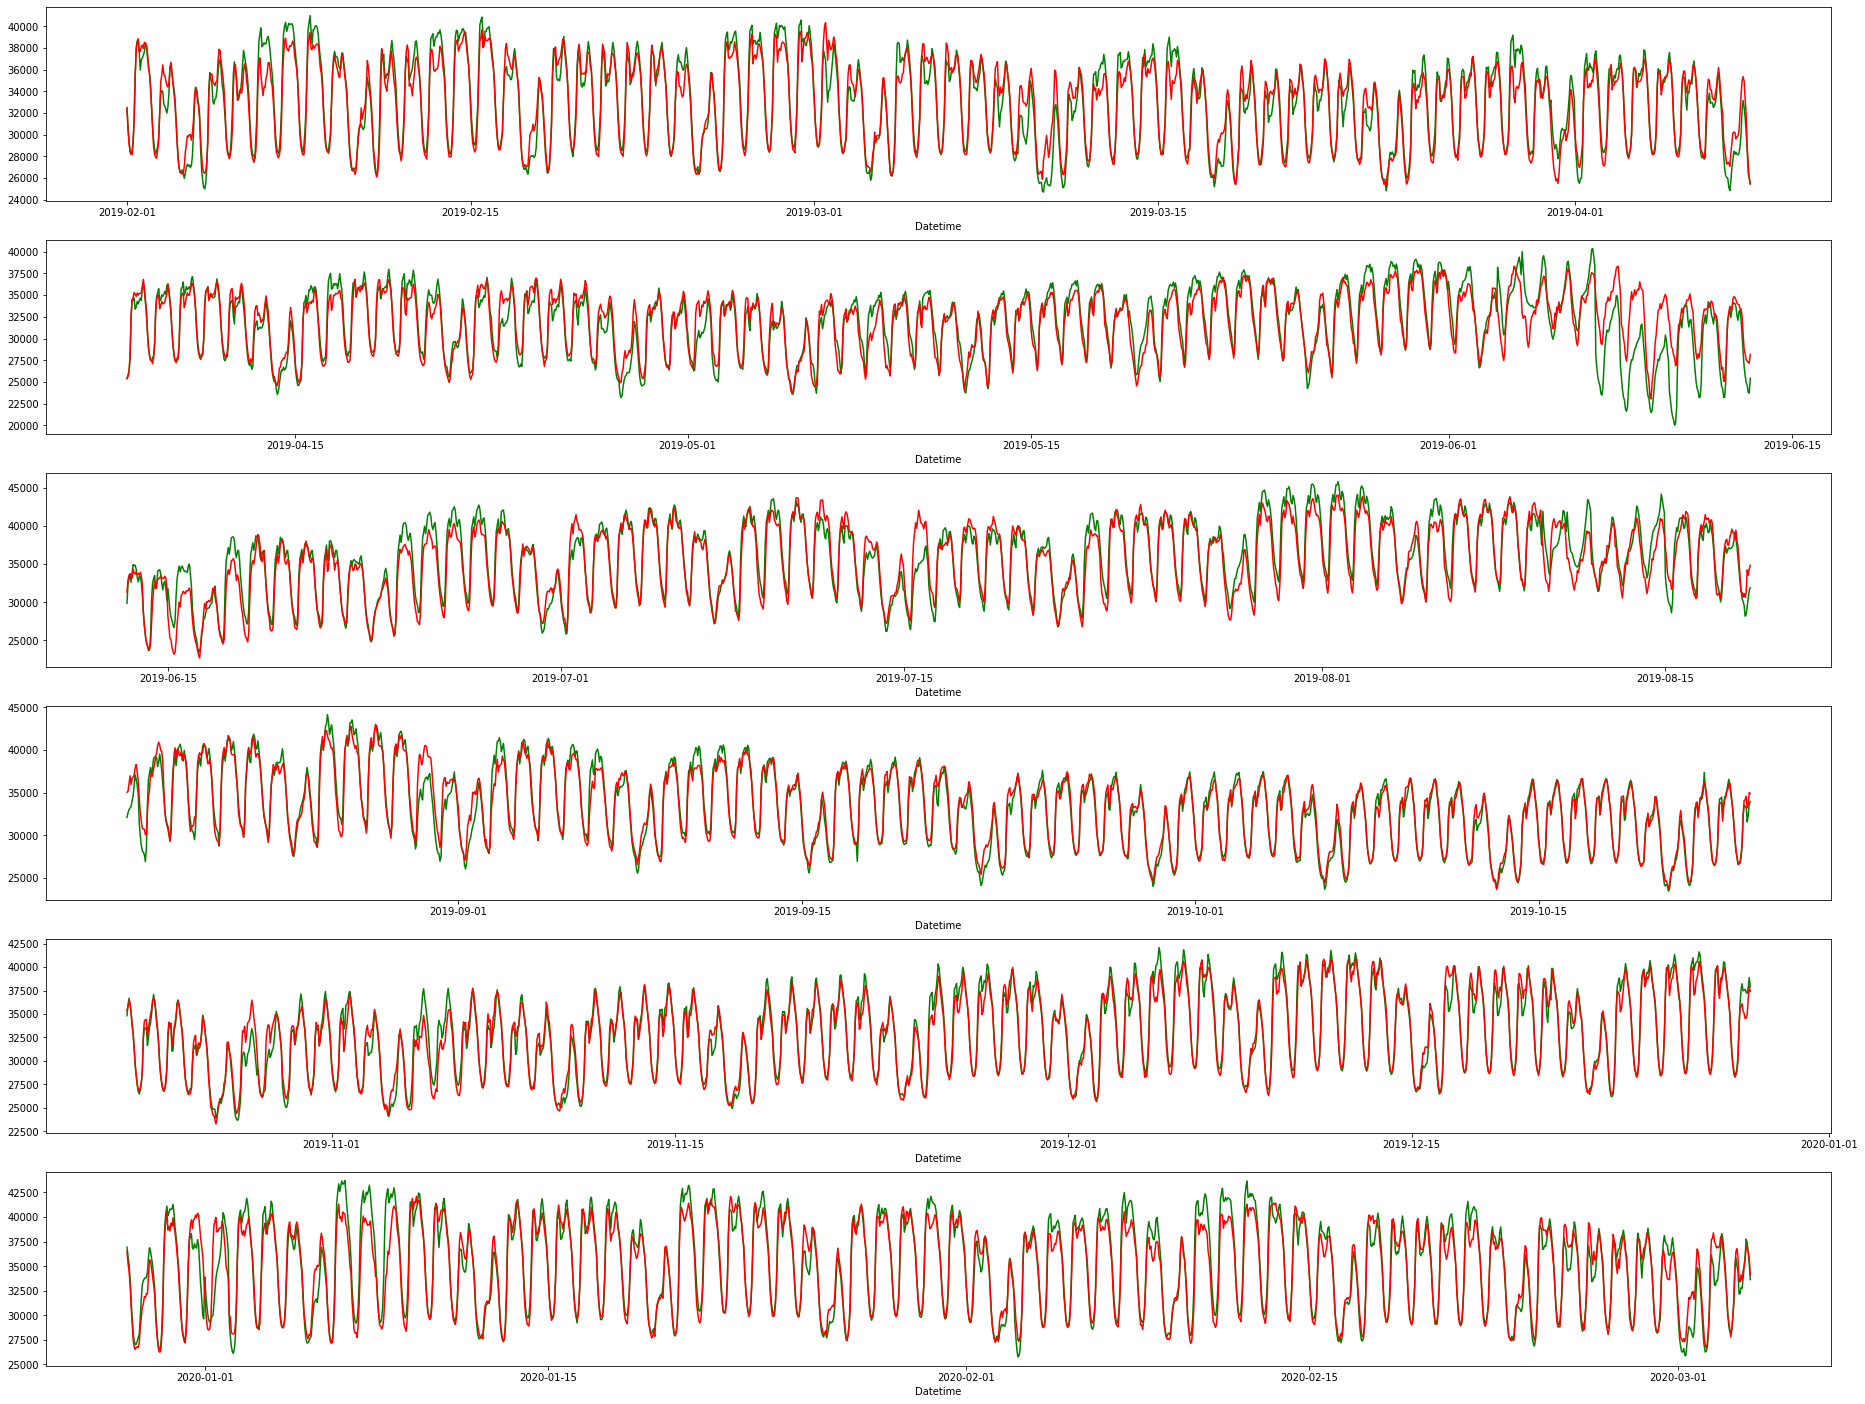

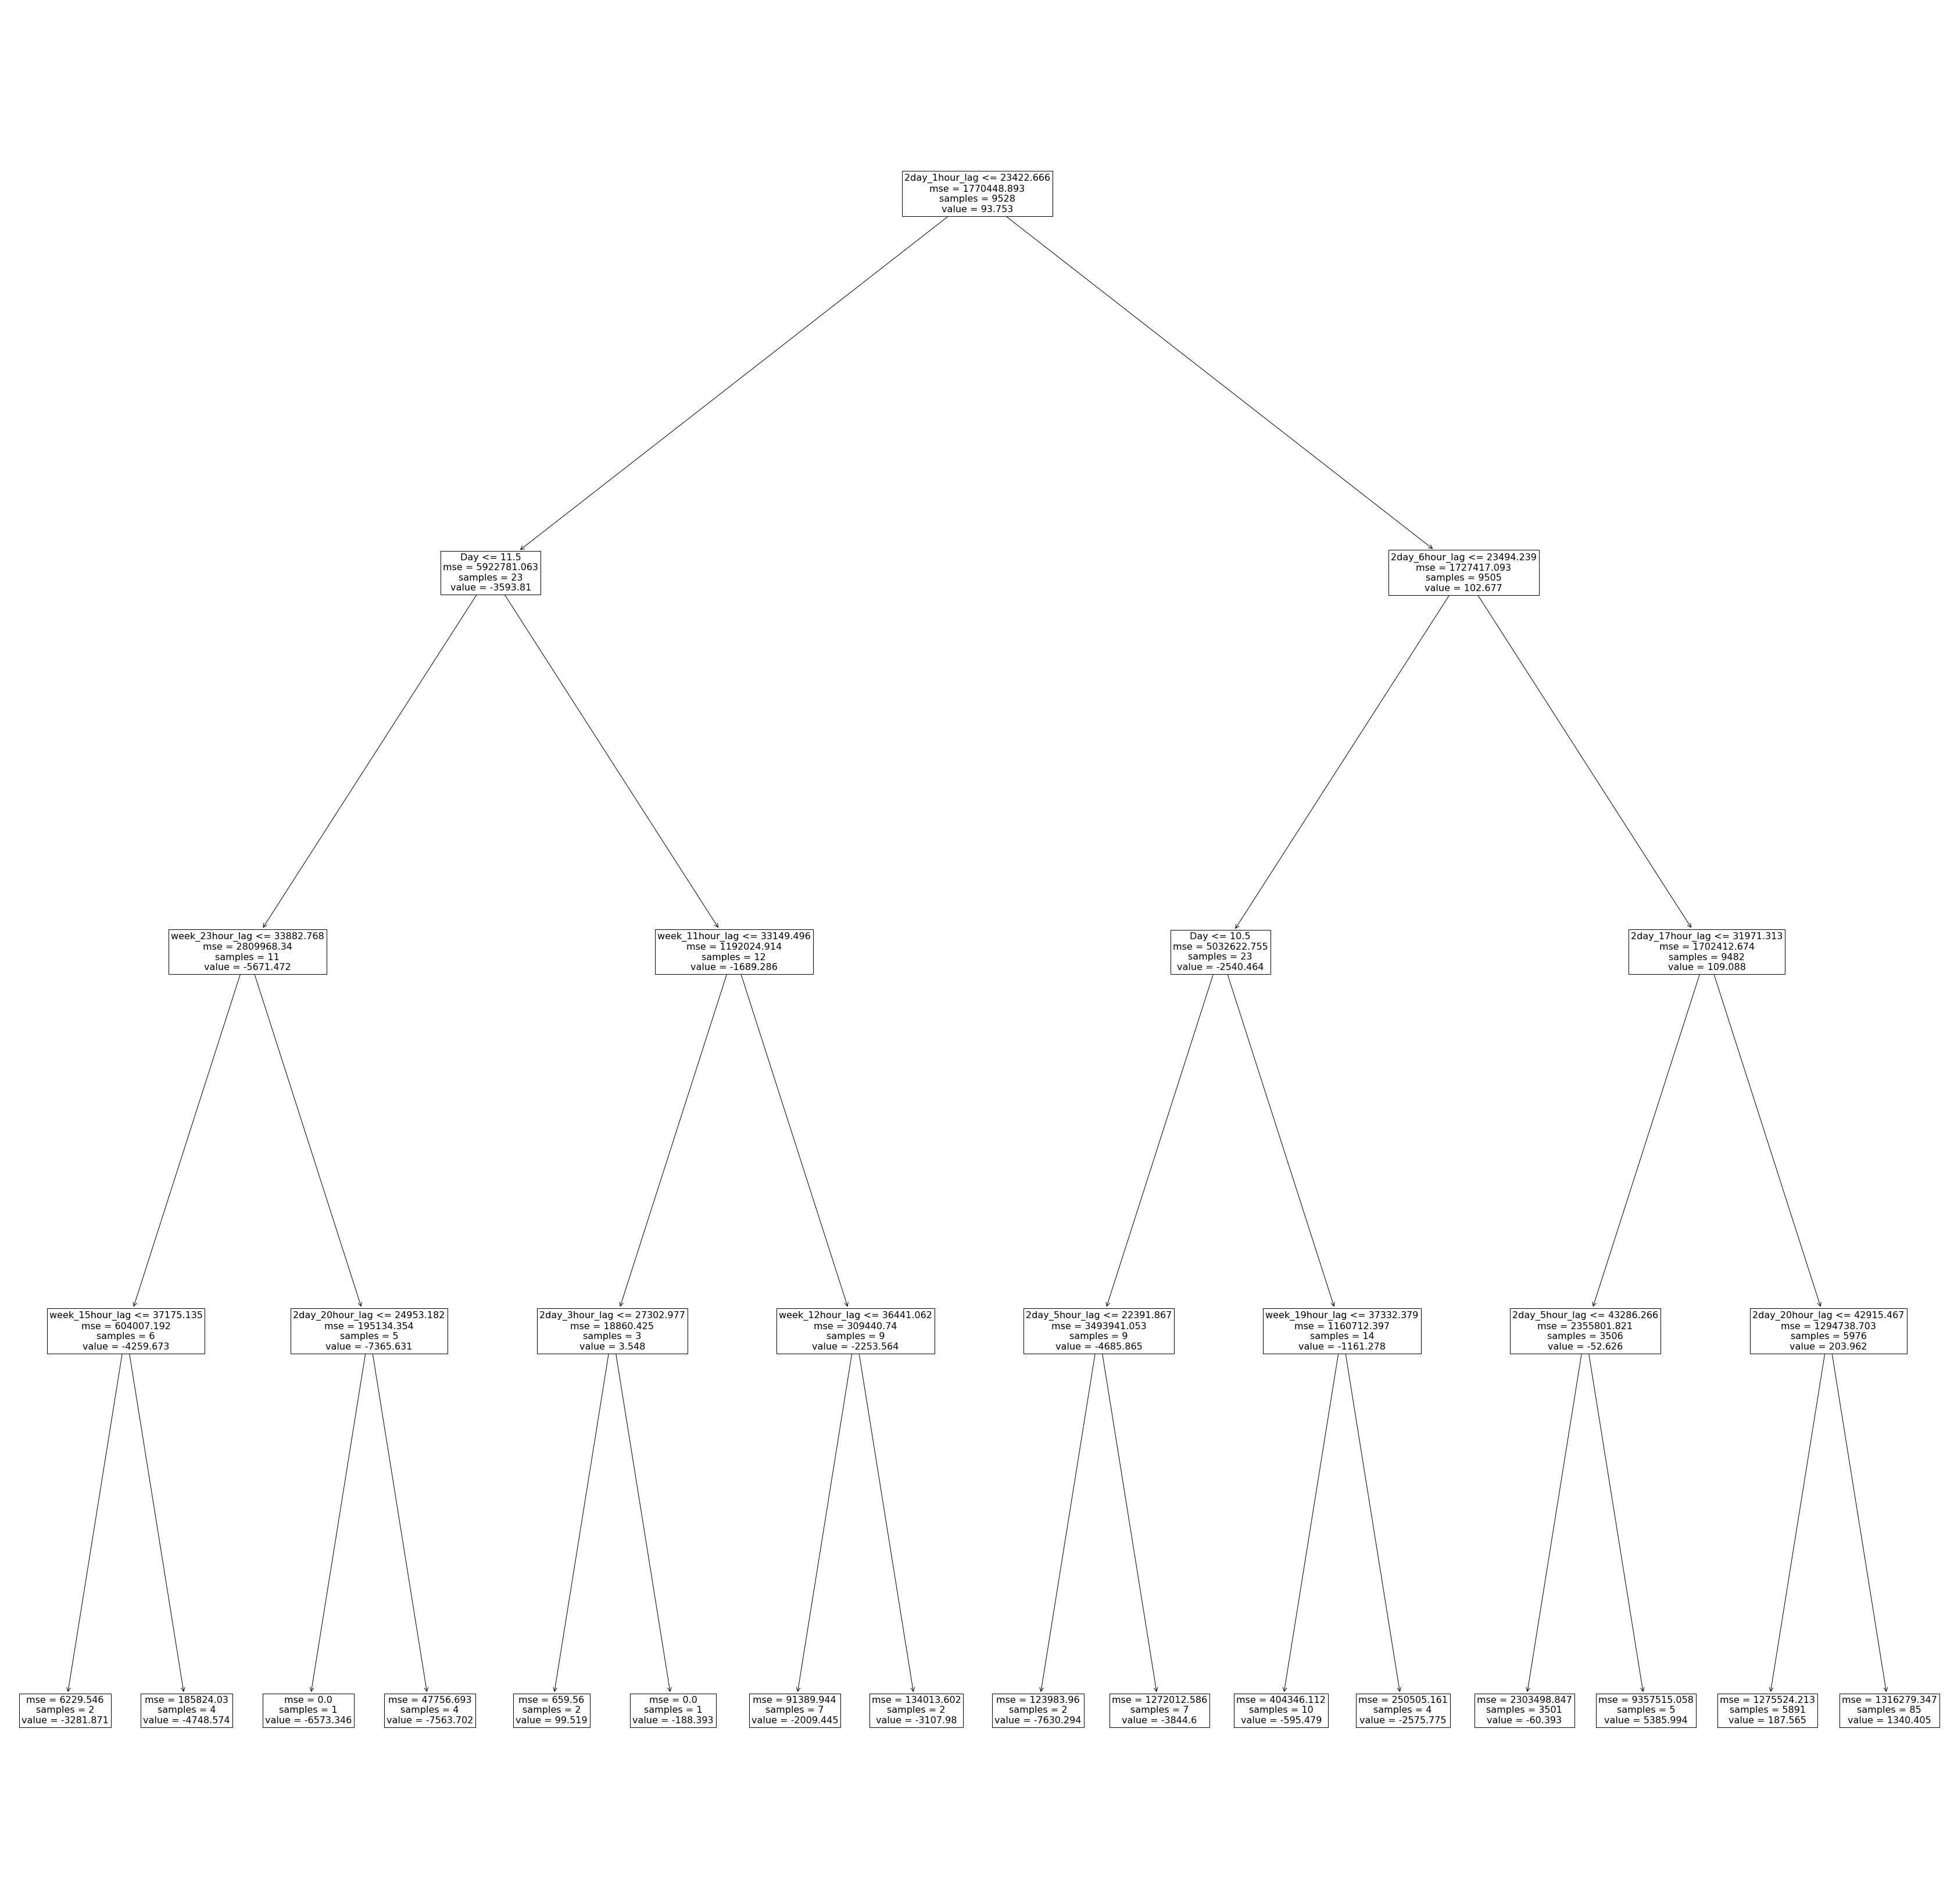

('Cat2',
 1333.8810326739833,
 0.0403666487875099,
 927.0124661267636,
 2.771364092909177)

In [0]:
y_pred=model.predict(valid_df[needed_colums])
y_true=valid_df["Consumption"].values
eval_function("Cat2",y_true,y_pred,valid_df[needed_colums.tolist()+["Datetime"]])

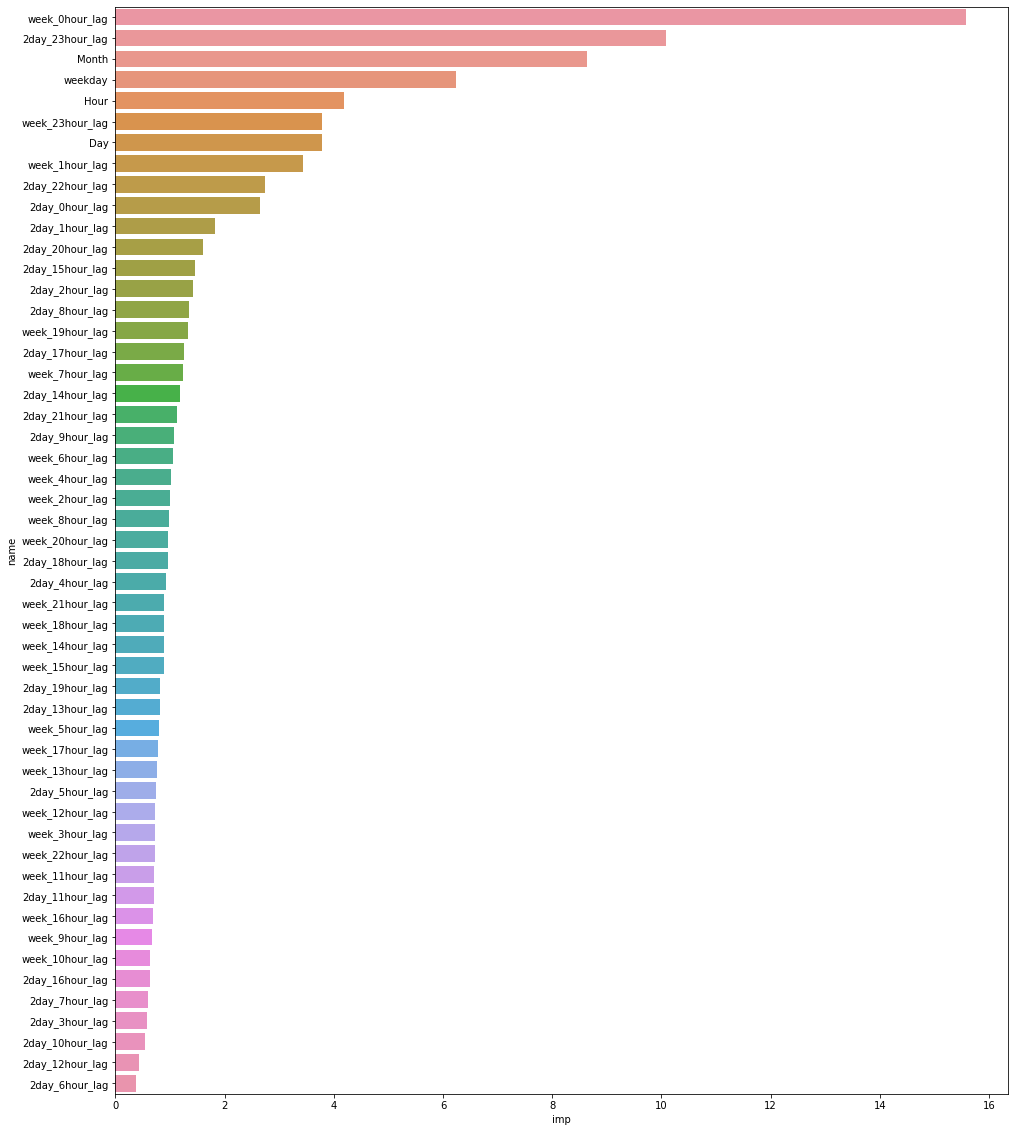

In [0]:
imp_df=pd.DataFrame()
imp_df["imp"]=model.feature_importances_
imp_df["name"]=model.feature_names_
plt.figure(figsize=(16,20))
sns.barplot(x="imp",y="name",data=imp_df.sort_values(by="imp",ascending=False))

In [0]:
y_pred

array([32378.19952877, 30471.1888216 , 29214.08044679, ...,
       36462.29853611, 35808.224367  , 34077.33202856])

array([31740.78402112, 29833.77331395, 28576.66493914, ...,
       36655.5554865 , 36001.48131739, 34270.58897895])

In [0]:
valid_df["Cat2_categorical"]=y_pred+valid_df[[i for i in valid_df.columns if i.startswith("is")]].sum(axis=1).values
valid_df[["Datetime","Cat2_categorical"]].to_csv("drive/My Drive/colab_datas/IE 492/kubi_preds/Cat2_categorical.csv",index=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# Keras

### Data fix for keras

In [0]:
## iki gün oncenin butun datasını alıcam 24 saatin yani
cat_df_1=cons_holiday_binary.copy()
cat_df_1["Hour"]=cat_df_1["Hour"].apply(lambda x:x.split(":")[0]).astype(int)
cat_df_1["Day"]=cat_df_1["Date"].apply(lambda x:x.split(".")[0]).astype(int)
cat_df_1["Month"]=cat_df_1["Date"].apply(lambda x:x.split(".")[1]).astype(int)
cat_df_1["weekday"]=pd.to_datetime(cat_df_1["Date"]).apply(lambda x: x.weekday()).astype(int)
# # hour lagging
# for hour in range(24):
#     cat_df_1["2day_{}hour_lag".format(hour)]=cat_df_1["Consumption"].shift(24*2-hour)

# # week lagging
# for hour in range(24):
#     cat_df_1["week_{}hour_lag".format(hour)]=cat_df_1["Consumption"].shift(24*7-hour)

# for week_num in range(10):
#     cat_df_1[]=cat_df_1["Consumption"].shift(24*2-hour)

for day_before in [2,7,7*2,7*3,7*4]:
    for hour in range(24):
        cat_df_1["conv_{}_day_{}_hour_lag".format(day_before,hour)]=cat_df_1["Consumption"].shift(day_before+hour)


cat_df_1=cat_df_1.dropna()
cat_df_1=cat_df_1.reset_index(drop=True)
cat_df_1

Date  Hour  ...  conv_28_day_22_hour_lag conv_28_day_23_hour_lag
0      02.01.2016     3  ...                 27785.43                29590.88
1      02.01.2016     4  ...                 26516.53                27785.43
2      02.01.2016     5  ...                 26091.62                26516.53
3      02.01.2016     6  ...                 25871.54                26091.62
4      02.01.2016     7  ...                 26053.84                25871.54
...           ...   ...  ...                      ...                     ...
36520  03.03.2020    19  ...                 30076.93                28485.01
36521  03.03.2020    20  ...                 32545.38                30076.93
36522  03.03.2020    21  ...                 35049.21                32545.38
36523  03.03.2020    22  ...                 34901.84                35049.21
36524  03.03.2020    23  ...                 34225.14                34901.84

[36525 rows x 166 columns]

In [0]:
train_df=cat_df_1.loc[cat_df_1["Datetime"]<pd.to_datetime("2019-02-01 00:00:00")]
valid_df=cat_df_1.loc[cat_df_1["Datetime"]>=pd.to_datetime("2019-02-01 00:00:00")]

In [0]:
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack

cat_features=[col for col in cat_df_1.columns if col.startswith("is")] # + ["Day","Month","weekday","Hour"]

# y_train

# linear_enc=OneHotEncoder()
# one_hot_encoded=linear_enc.fit_transform(cat_df_1[cat_features]).toarray()
# train_df=hstack([cat_df_1[cat_df_1.columns.difference(cat_features)].drop(columns=["Consumption","Date","Datetime"]).astype(float),one_hot_encoded])
# ## dataframe cevirip hallet
cat_features

['is_annelergunu',
 'is_arife',
 'is_babalargunu',
 'is_cocukbayrami',
 'is_cumhuriyet',
 'is_elections',
 'is_examination',
 'is_genclikbayrami',
 'is_holiday',
 'is_iscibayrami',
 'is_kadinlargunu',
 'is_kandil',
 'is_kurbanbayrami',
 'is_kurbanbayramilkgun',
 'is_kurbanoncesigunler',
 'is_onbestemmuz',
 'is_outlierdays',
 'is_ramazanbayrami',
 'is_ramazanbayramilkgun',
 'is_ramazanbayramisonrasi',
 'is_ramazangunler',
 'is_ramazanilkgun',
 'is_ramazanoncesigunler',
 'is_school_days',
 'is_school_end',
 'is_school_start',
 'is_semester',
 'is_semester_days',
 'is_sevgililergunu',
 'is_single_day_holidays',
 'is_summerTimes',
 'is_summer_break',
 'is_uzunbayram',
 'is_winterTimes',
 'is_winter_break',
 'is_winter_break_schools',
 'is_yilbasi',
 'is_yilbasioncesi',
 'is_zaferbayrami']

### modellnig

In [0]:
!pip install --upgrade keras

from keras import backend as K
import keras
from keras.layers import Dense,Input,Conv2D,MaxPooling2D,Activation,Flatten,Dropout,Cropping2D,Lambda,GlobalAveragePooling2D,BatchNormalization,AveragePooling2D
from keras.models import Sequential,Model

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.3.1)


Using TensorFlow backend.


In [0]:
# from keras.applications.densenet import DenseNet121, preprocess_input
from keras.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error
from keras.optimizers import Adam, SGD, rmsprop

# def root_mean_squared_log_error(y_true, y_pred):
#     return K.sqrt(mean_squared_log_error(y_true.toarray(), y_pred.toarray()))

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
            EarlyStopping(patience=15, verbose=1),
            ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1)
            ]

In [0]:
# basic dense model
from keras.models import Model
from keras.layers import Input, Dense

a = Input(shape=(91,))
d = Dense(1024, activation='relu')(a)
c = Dense(512, activation='relu')(d)
output_layer=Dense(1)(c)
model = Model(inputs=a, outputs=output_layer)

In [0]:
model.compile(optimizer=Adam(lr=1e-3, decay=1e-9), loss=mean_absolute_percentage_error, metrics=[mean_absolute_error,mean_absolute_percentage_error,root_mean_squared_error,
                                                                                                #  root_mean_squared_log_error
                                                                                                 ])
model.fit(train_df.drop(columns=["Date","Datetime","Consumption"]),train_df["Consumption"],batch_size=24,epochs=1000,validation_data=(valid_df.drop(columns=["Date","Datetime","Consumption"]),valid_df["Consumption"]))

Train on 26880 samples, validate on 9528 samples
Epoch 1/1000
26880/26880 [==============================] - 8s 306us/step - loss: 6.1737 - mean_absolute_error: 1978.3329 - mean_absolute_percentage_error: 6.1737 - root_mean_squared_error: 2582.2280 - val_loss: 5.8478 - val_mean_absolute_error: 1865.4454 - val_mean_absolute_percentage_error: 5.8478 - val_root_mean_squared_error: 2062.4600
Epoch 2/1000
26880/26880 [==============================] - 7s 248us/step - loss: 4.7385 - mean_absolute_error: 1527.1827 - mean_absolute_percentage_error: 4.7385 - root_mean_squared_error: 2116.3914 - val_loss: 4.1251 - val_mean_absolute_error: 1354.2235 - val_mean_absolute_percentage_error: 4.1251 - val_root_mean_squared_error: 1605.1436
Epoch 3/1000
26880/26880 [==============================] - 7s 244us/step - loss: 4.3245 - mean_absolute_error: 1393.9556 - mean_absolute_percentage_error: 4.3245 - root_mean_squared_error: 1970.8774 - val_loss: 4.2702 - val_mean_absolute_error: 1397.8109 - val_mean_

RMSE:  1988.4382
RMSLE:  0.062285724558912334
MAE:  tf.Tensor(1248.1774, shape=(), dtype=float32)
MAPE:  tf.Tensor(3.8238955, shape=(), dtype=float32)


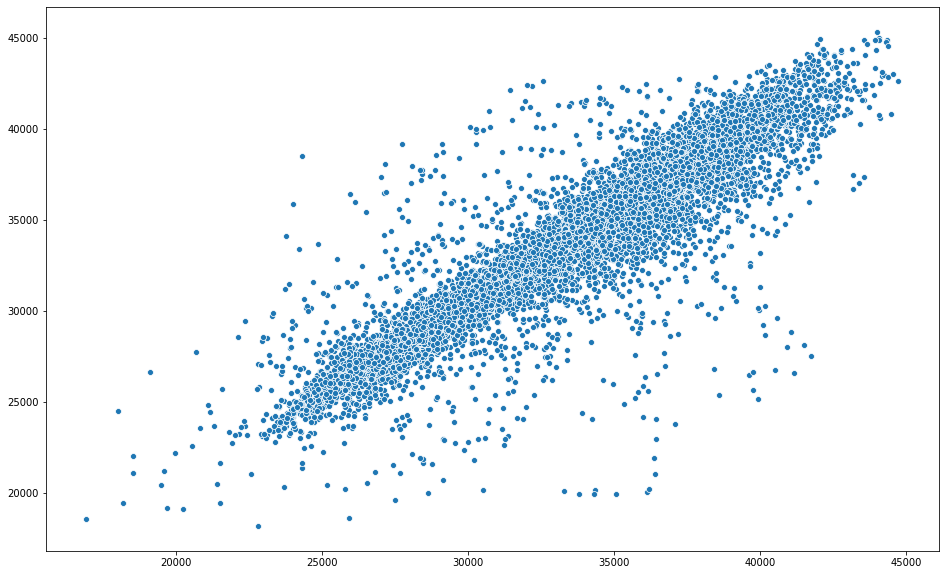

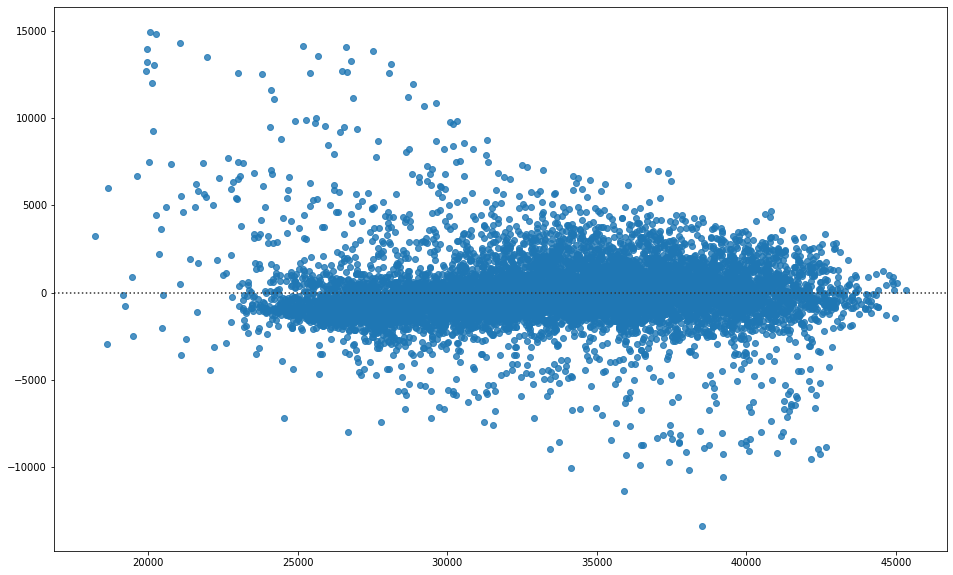

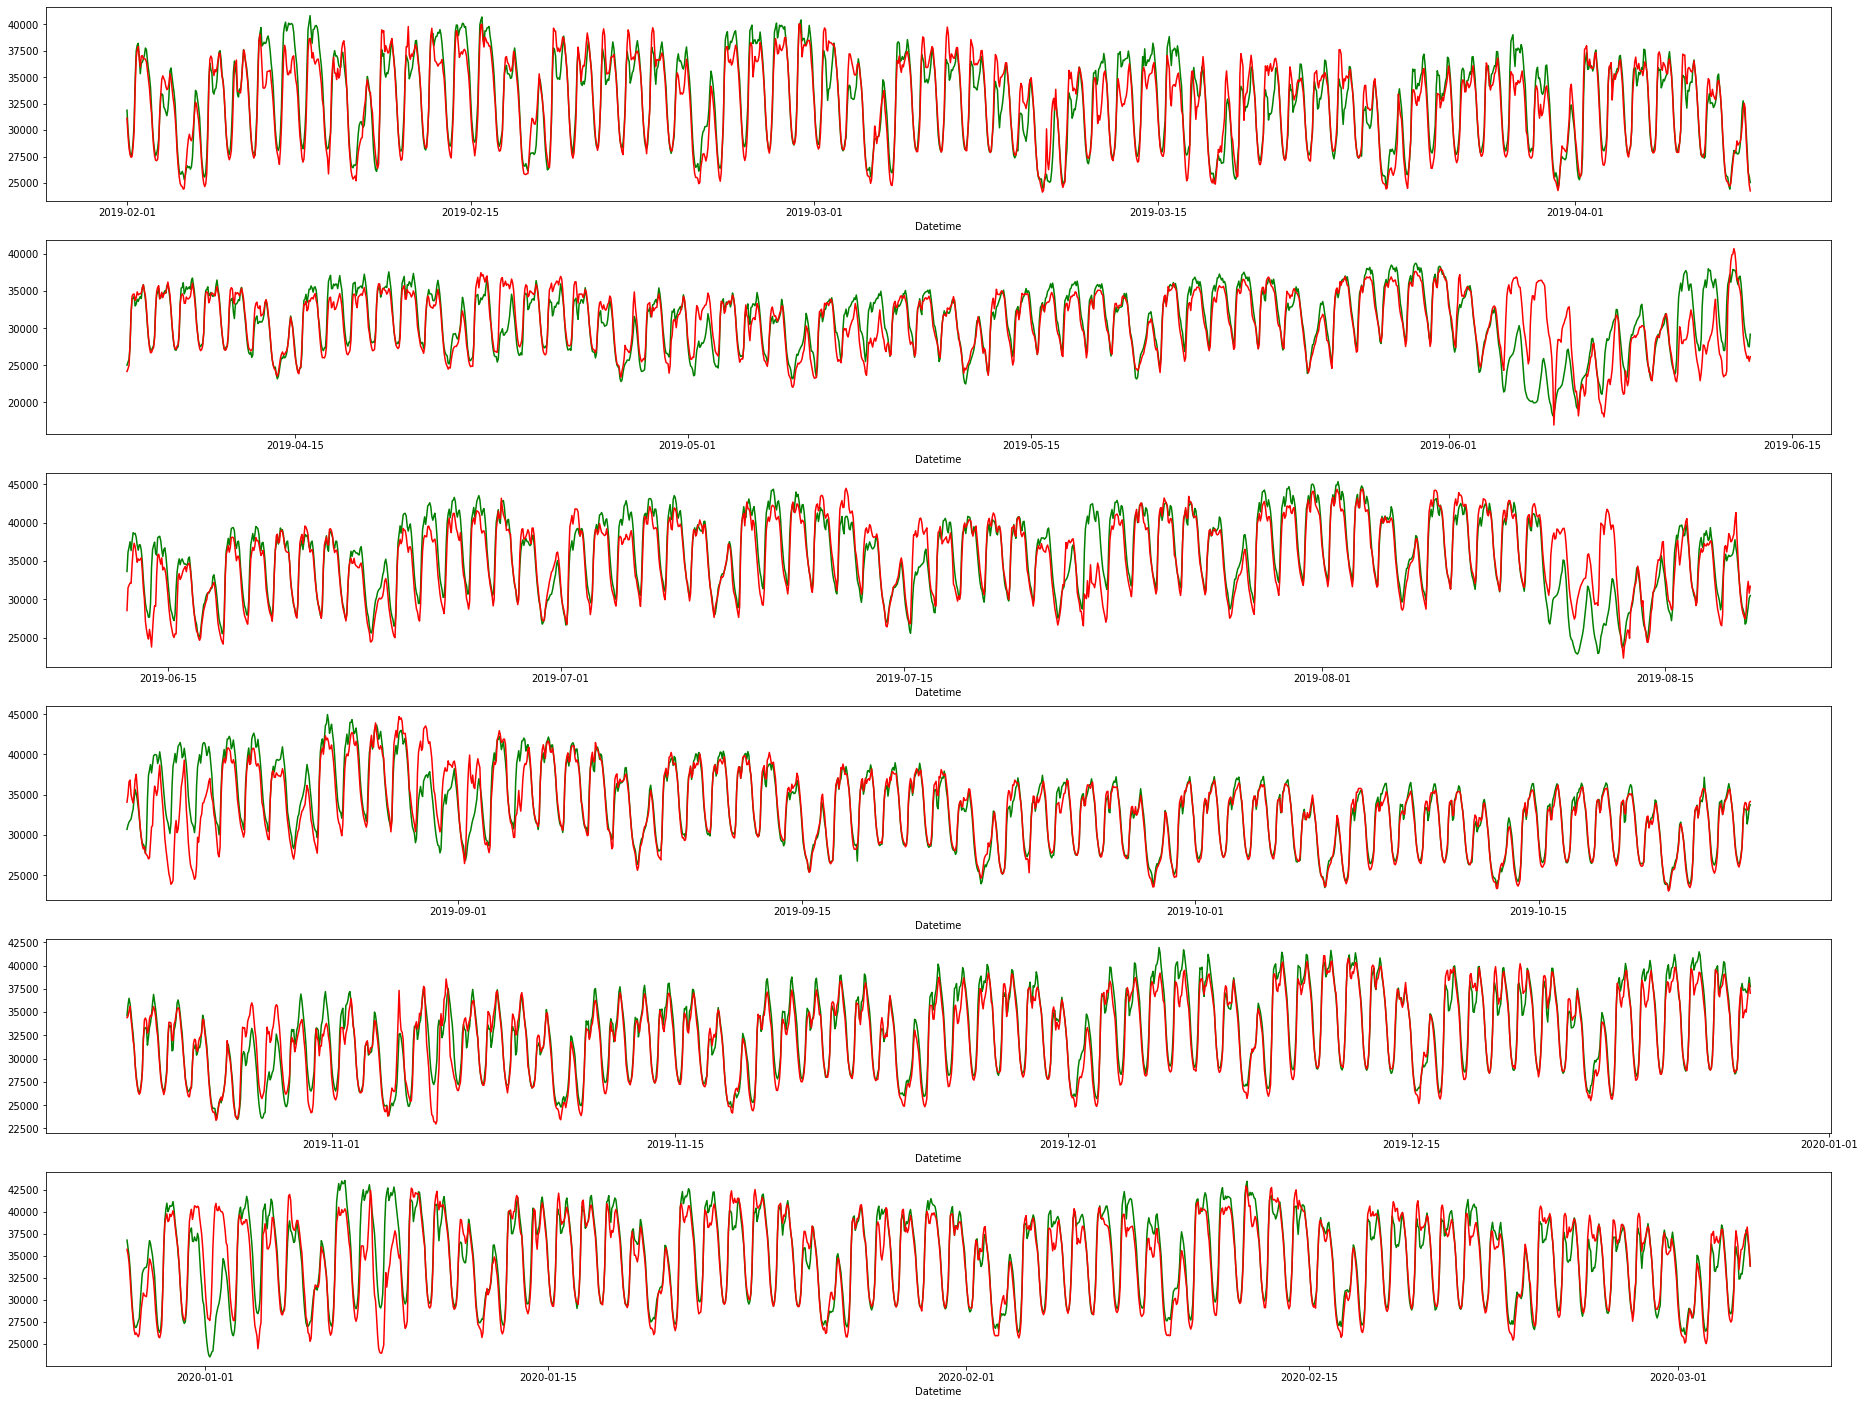

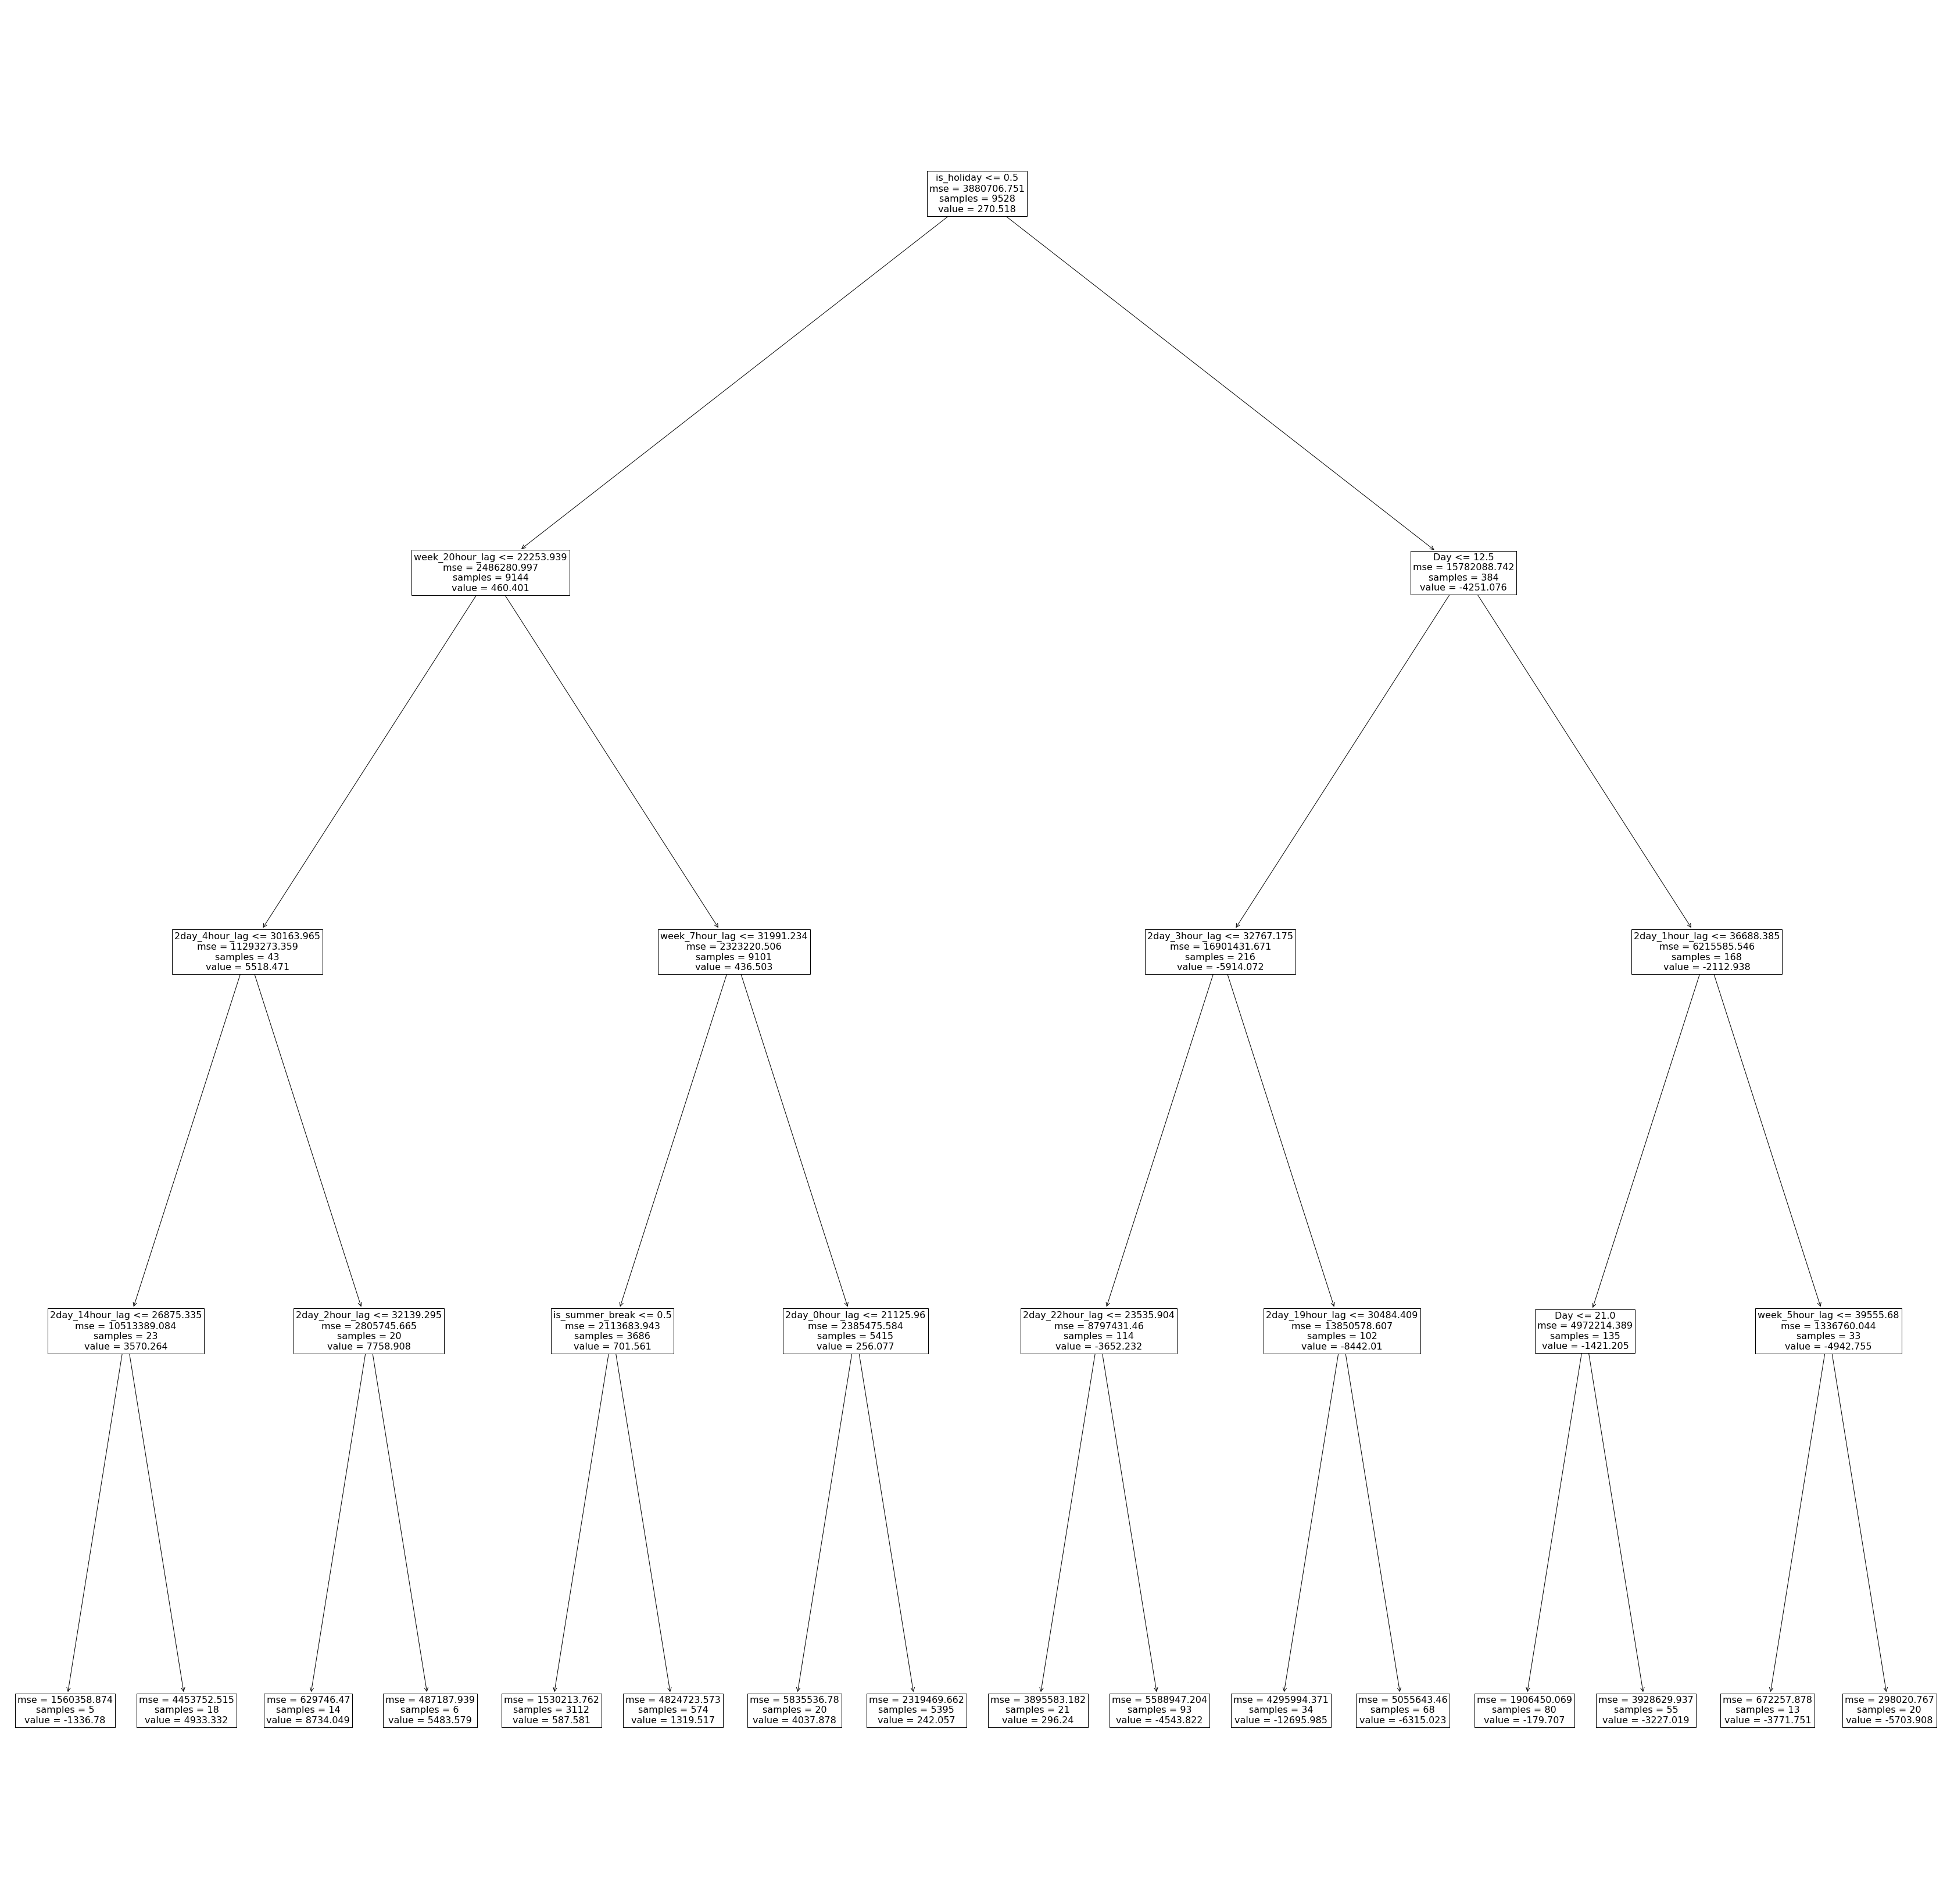

('Keras',
 1988.4382,
 0.062285724558912334,
 <tf.Tensor: shape=(), dtype=float32, numpy=1248.1774>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3.8238955>)

In [0]:
y_pred=model.predict(valid_df.drop(columns=["Date","Datetime","Consumption"])).reshape((1,-1))[0]
y_true=valid_df["Consumption"].values
eval_function("Keras",y_true,y_pred,valid_df.drop(columns=["Date","Consumption"]))

# LSTM

### Data fix for keras

In [0]:
## iki gün oncenin butun datasını alıcam 24 saatin yani
cat_df_1=cons_holiday_binary.copy()
cat_df_1["Hour"]=cat_df_1["Hour"].apply(lambda x:x.split(":")[0]).astype(int)
cat_df_1["Day"]=cat_df_1["Date"].apply(lambda x:x.split(".")[0]).astype(int)
cat_df_1["Month"]=cat_df_1["Date"].apply(lambda x:x.split(".")[1]).astype(int)
cat_df_1["weekday"]=pd.to_datetime(cat_df_1["Date"]).apply(lambda x: x.weekday()).astype(int)
# # hour lagging
# for hour in range(24):
#     cat_df_1["2day_{}hour_lag".format(hour)]=cat_df_1["Consumption"].shift(24*2-hour)

# # week lagging
# for hour in range(24):
#     cat_df_1["week_{}hour_lag".format(hour)]=cat_df_1["Consumption"].shift(24*7-hour)

# for week_num in range(10):
#     cat_df_1[]=cat_df_1["Consumption"].shift(24*2-hour)

for day_before in [2,7,7*2,7*3,7*4]:
    for hour in range(24):
        cat_df_1["conv_{}_day_{}_hour_lag".format(day_before,hour)]=cat_df_1["Consumption"].shift(day_before+hour)


cat_df_1=cat_df_1.dropna()
cat_df_1=cat_df_1.reset_index(drop=True)
cat_df_1

Date  Hour  ...  conv_28_day_22_hour_lag conv_28_day_23_hour_lag
0      02.01.2016     3  ...                 27785.43                29590.88
1      02.01.2016     4  ...                 26516.53                27785.43
2      02.01.2016     5  ...                 26091.62                26516.53
3      02.01.2016     6  ...                 25871.54                26091.62
4      02.01.2016     7  ...                 26053.84                25871.54
...           ...   ...  ...                      ...                     ...
36520  03.03.2020    19  ...                 30076.93                28485.01
36521  03.03.2020    20  ...                 32545.38                30076.93
36522  03.03.2020    21  ...                 35049.21                32545.38
36523  03.03.2020    22  ...                 34901.84                35049.21
36524  03.03.2020    23  ...                 34225.14                34901.84

[36525 rows x 166 columns]

In [0]:
train_df=cat_df_1.loc[cat_df_1["Datetime"]<pd.to_datetime("2019-02-01 00:00:00")]
valid_df=cat_df_1.loc[cat_df_1["Datetime"]>=pd.to_datetime("2019-02-01 00:00:00")]

In [0]:
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack

cat_features=[col for col in cat_df_1.columns if col.startswith("is")] # + ["Day","Month","weekday","Hour"]

# y_train

# linear_enc=OneHotEncoder()
# one_hot_encoded=linear_enc.fit_transform(cat_df_1[cat_features]).toarray()
# train_df=hstack([cat_df_1[cat_df_1.columns.difference(cat_features)].drop(columns=["Consumption","Date","Datetime"]).astype(float),one_hot_encoded])
# ## dataframe cevirip hallet
cat_features

['is_annelergunu',
 'is_arife',
 'is_babalargunu',
 'is_cocukbayrami',
 'is_cumhuriyet',
 'is_elections',
 'is_examination',
 'is_genclikbayrami',
 'is_holiday',
 'is_iscibayrami',
 'is_kadinlargunu',
 'is_kandil',
 'is_kurbanbayrami',
 'is_kurbanbayramilkgun',
 'is_kurbanoncesigunler',
 'is_onbestemmuz',
 'is_outlierdays',
 'is_ramazanbayrami',
 'is_ramazanbayramilkgun',
 'is_ramazanbayramisonrasi',
 'is_ramazangunler',
 'is_ramazanilkgun',
 'is_ramazanoncesigunler',
 'is_school_days',
 'is_school_end',
 'is_school_start',
 'is_semester',
 'is_semester_days',
 'is_sevgililergunu',
 'is_single_day_holidays',
 'is_summerTimes',
 'is_summer_break',
 'is_uzunbayram',
 'is_winterTimes',
 'is_winter_break',
 'is_winter_break_schools',
 'is_yilbasi',
 'is_yilbasioncesi',
 'is_zaferbayrami']

In [0]:
def fix_df_lstm(cat_df_1):
    dense_part=cat_df_1[[i for i in cat_df_1.columns if not i.startswith("conv") and not i.startswith("Date")]].copy().drop(columns=["Consumption"])
    label=cat_df_1["Consumption"]
    lag_part=cat_df_1[[i for i in cat_df_1.columns if i.startswith("conv")]]
    conv_means=[]
    conv_vars=[]
    for row in tqdm(lag_part.values):
        conv_means.append([np.mean([np.full(len(row),val_),row],axis=0) for val_ in row])
        conv_vars.append([np.var([np.full(len(row),val_),row],axis=0) for val_ in row])
    conv_means=np.array(conv_means)
    conv_means=conv_means.reshape(list(conv_means.shape)+[1])
    conv_vars=np.array(conv_vars)
    conv_vars=conv_vars.reshape(list(conv_vars.shape)+[1])
    return dense_part,conv_means,conv_vars,label

In [0]:
dense_part,conv_means,conv_vars,label=fix_df_lstm(train_df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


### modellnig

In [0]:
!pip install --upgrade keras

from keras import backend as K
import keras
from keras.layers import Dense,Input,Conv2D,MaxPooling2D,Activation,Flatten,Dropout,Cropping2D,Lambda,GlobalAveragePooling2D,BatchNormalization,AveragePooling2D,LSTM
from keras.models import Sequential,Model

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.3.1)


Using TensorFlow backend.


In [0]:
# from keras.applications.densenet import DenseNet121, preprocess_input
from keras.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error
from keras.optimizers import Adam, SGD, rmsprop

# def root_mean_squared_log_error(y_true, y_pred):
#     return K.sqrt(mean_squared_log_error(y_true.toarray(), y_pred.toarray()))

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
            EarlyStopping(patience=15, verbose=1),
            ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1)
            ]

In [0]:
# basic dense model
from keras.models import Model
from keras.layers import Input, Dense,Concatenate

flat_input = Input(shape=(43,))
mean_input = Input(shape=(120,120,1))
var_input = Input(shape=(120,120,1))

## mean_part

conv_1=Conv2D(48, kernel_size=(12, 12), strides=(1, 1),
                 activation='relu')(mean_input)
maxp_1=MaxPooling2D(pool_size=(6, 6), strides=(2, 2))(conv_1)
conv_2=Conv2D(24, kernel_size=(12, 12), strides=(1, 1),
                 activation='relu')(maxp_1)
maxp_2=MaxPooling2D(pool_size=(6, 6), strides=(2, 2))(conv_2)
flatt_mean=Flatten()(maxp_2)

## variance_part

conv_1=Conv2D(48, kernel_size=(12, 12), strides=(1, 1),
                 activation='relu')(var_input)
maxp_1=MaxPooling2D(pool_size=(6, 6), strides=(2, 2))(conv_1)
conv_2=Conv2D(24, kernel_size=(12, 12), strides=(1, 1),
                 activation='relu')(maxp_1)
maxp_2=MaxPooling2D(pool_size=(6, 6), strides=(2, 2))(conv_2)
flatt_var=Flatten()(maxp_2)

## flat input

concat = Concatenate()([flatt_mean, flatt_var,flat_input])

mid_dense = Dense(1024, activation='relu')(concat)
drop_1=Dropout(0.3)(mid_dense)
lstm_1=LSTM(500, activation='relu',input_shape=(1,1))(drop_1)
lstm_2=LSTM(250, activation='relu')(lstm_1)
drop_2=Dropout(0.3)(lstm_2)
lstm_3=LSTM(250, activation='relu')(drop_2)
mid_dense_1 = Dense(512, activation='relu')(lstm_3)
output_layer = Dense(1)(mid_dense_1)
model=Model(inputs=[mean_input, var_input, flat_input], outputs=output_layer)
model.summary()

Using TensorFlow backend.


NameError: ignored

In [0]:
valid_dense_part,valid_conv_means,valid_conv_vars,valid_label=fix_df_lstm(valid_df)

In [0]:
model.compile(optimizer=Adam(lr=1e-2, decay=1e-7), loss=mean_absolute_percentage_error, metrics=[mean_absolute_error,mean_absolute_percentage_error,root_mean_squared_error,
                                                                                                #  root_mean_squared_log_error
                                                                                                 ])
model.fit([conv_means,conv_vars,dense_part],label,validation_data=([valid_conv_means,valid_conv_vars,valid_dense_part],valid_label),epochs=1000,batch_size=200)

Train on 26997 samples, validate on 9528 samples
Epoch 1/1000
26997/26997 [==============================] - 21s 779us/step - loss: 28.8994 - mean_absolute_error: 9395.4014 - mean_absolute_percentage_error: 28.8994 - root_mean_squared_error: 10265.8564 - val_loss: 9.7129 - val_mean_absolute_error: 3360.6670 - val_mean_absolute_percentage_error: 9.7129 - val_root_mean_squared_error: 4050.8098
Epoch 2/1000
26997/26997 [==============================] - 21s 774us/step - loss: 9.7791 - mean_absolute_error: 3201.7773 - mean_absolute_percentage_error: 9.7791 - root_mean_squared_error: 4011.4829 - val_loss: 8.3396 - val_mean_absolute_error: 2823.8621 - val_mean_absolute_percentage_error: 8.3396 - val_root_mean_squared_error: 3450.4492
Epoch 3/1000
26997/26997 [==============================] - 21s 771us/step - loss: 9.4215 - mean_absolute_error: 3082.9663 - mean_absolute_percentage_error: 9.4215 - root_mean_squared_error: 3829.9722 - val_loss: 9.5171 - val_mean_absolute_error: 3311.5371 - val

KeyboardInterrupt: ignored

RMSE:  1988.4382
RMSLE:  0.062285724558912334
MAE:  tf.Tensor(1248.1774, shape=(), dtype=float32)
MAPE:  tf.Tensor(3.8238955, shape=(), dtype=float32)


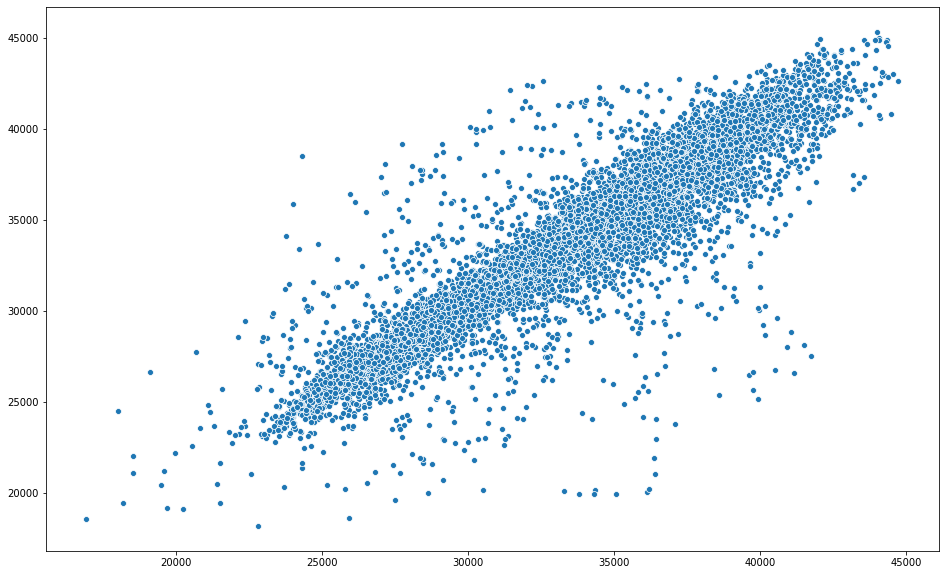

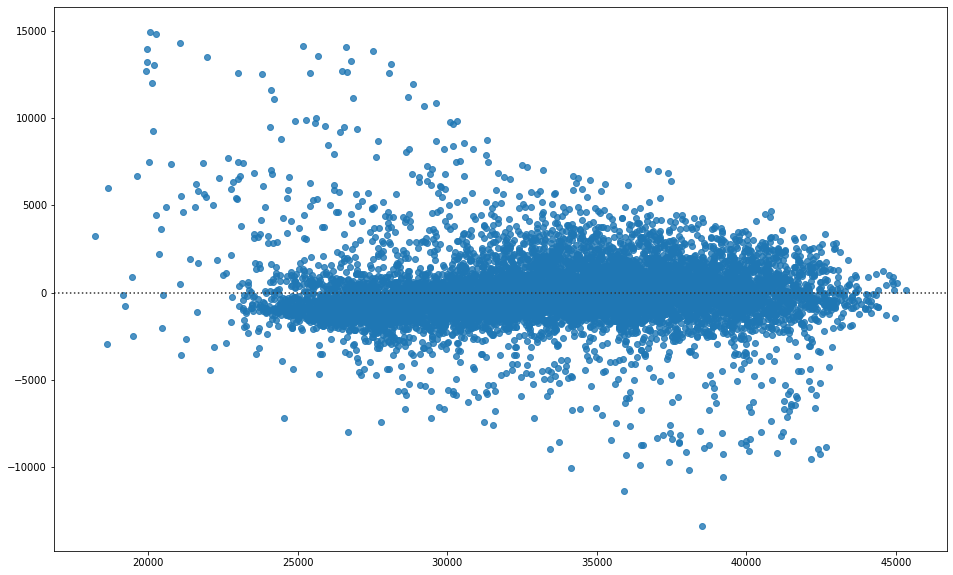

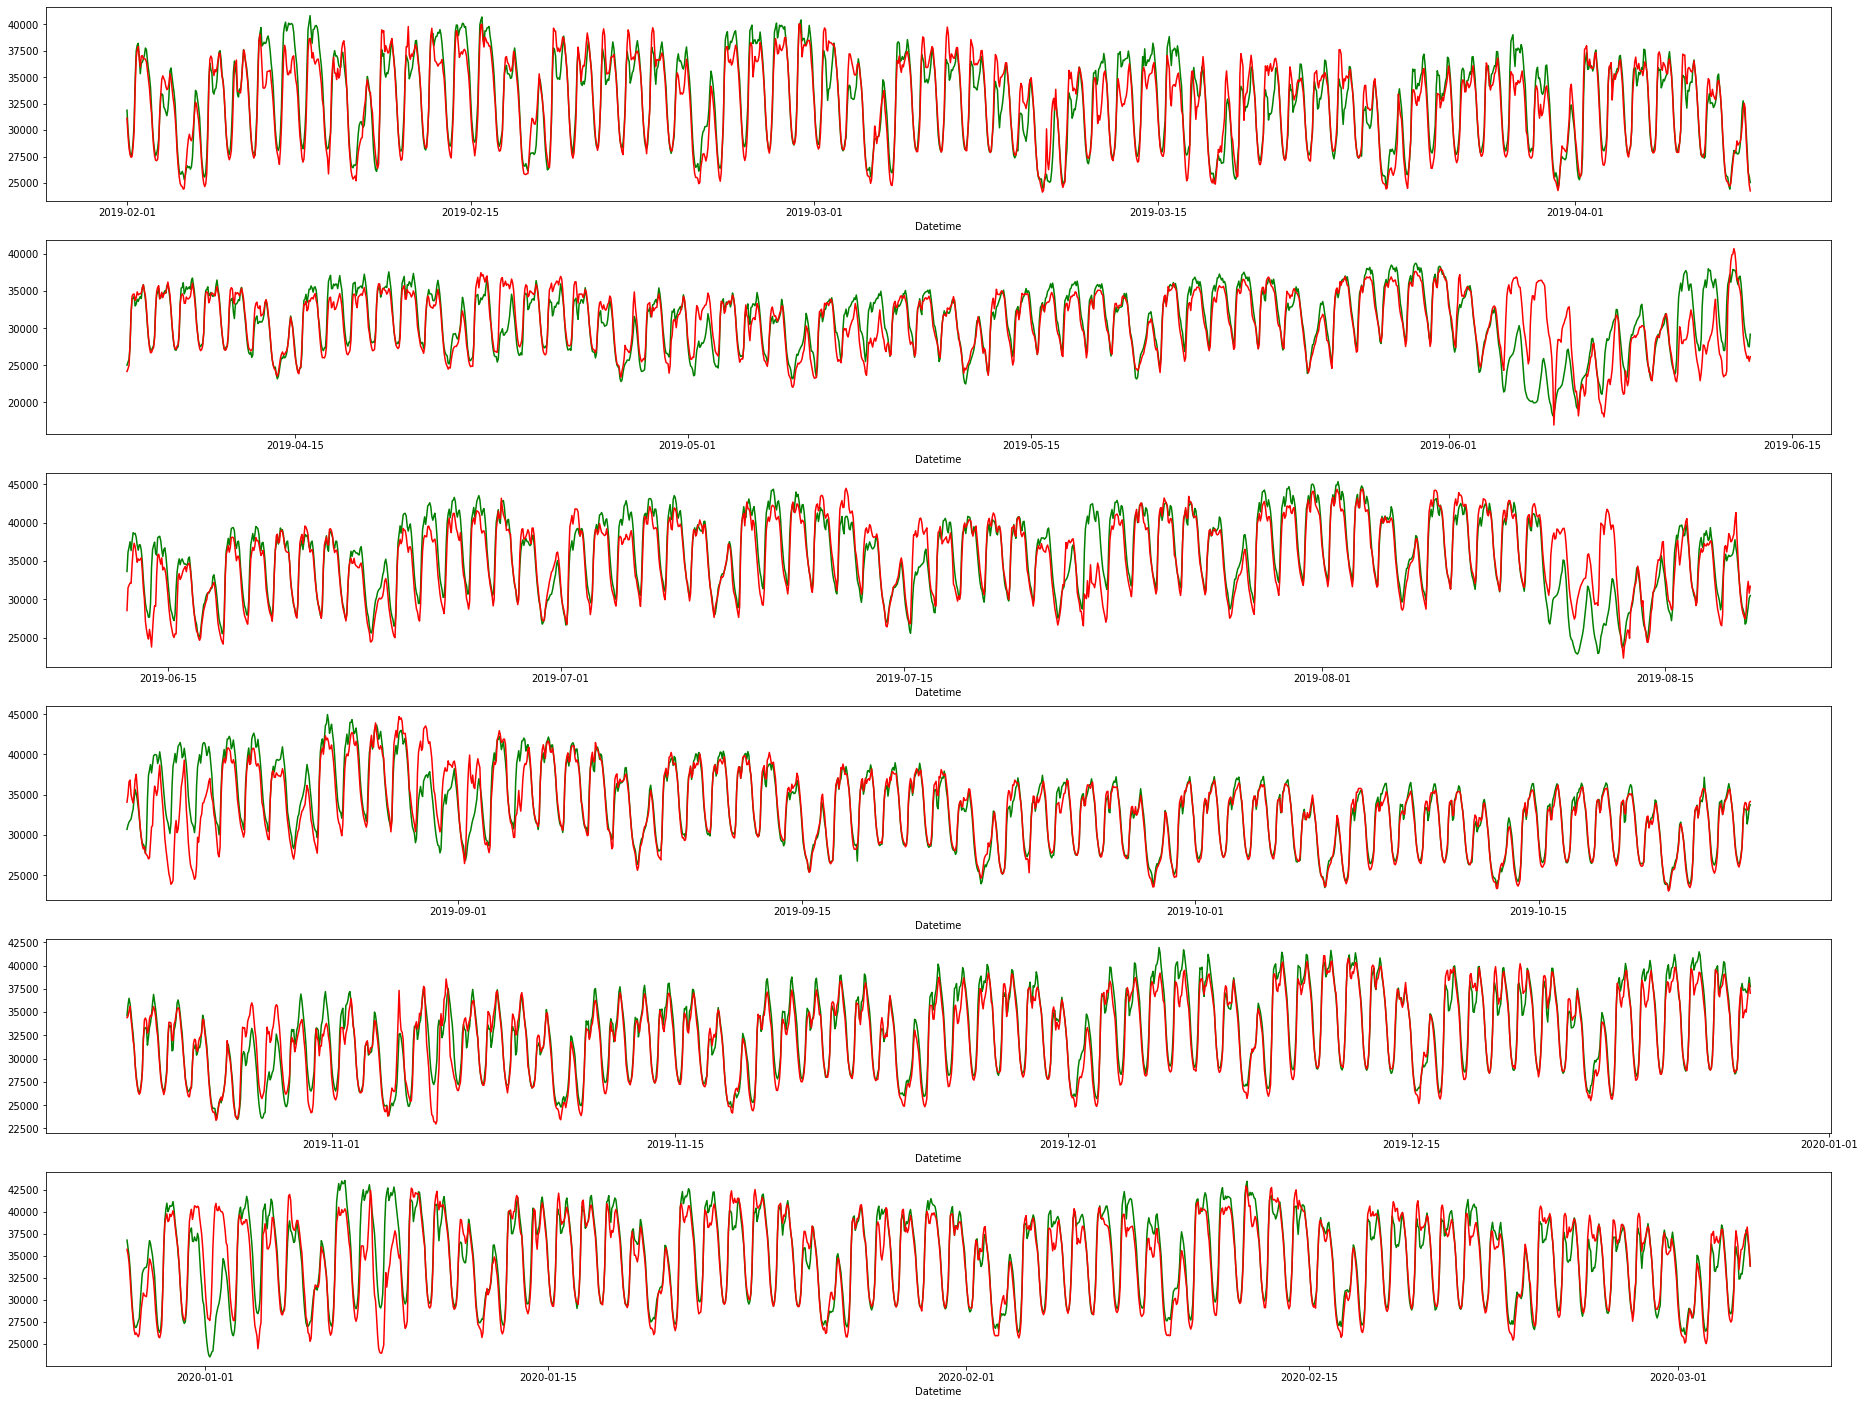

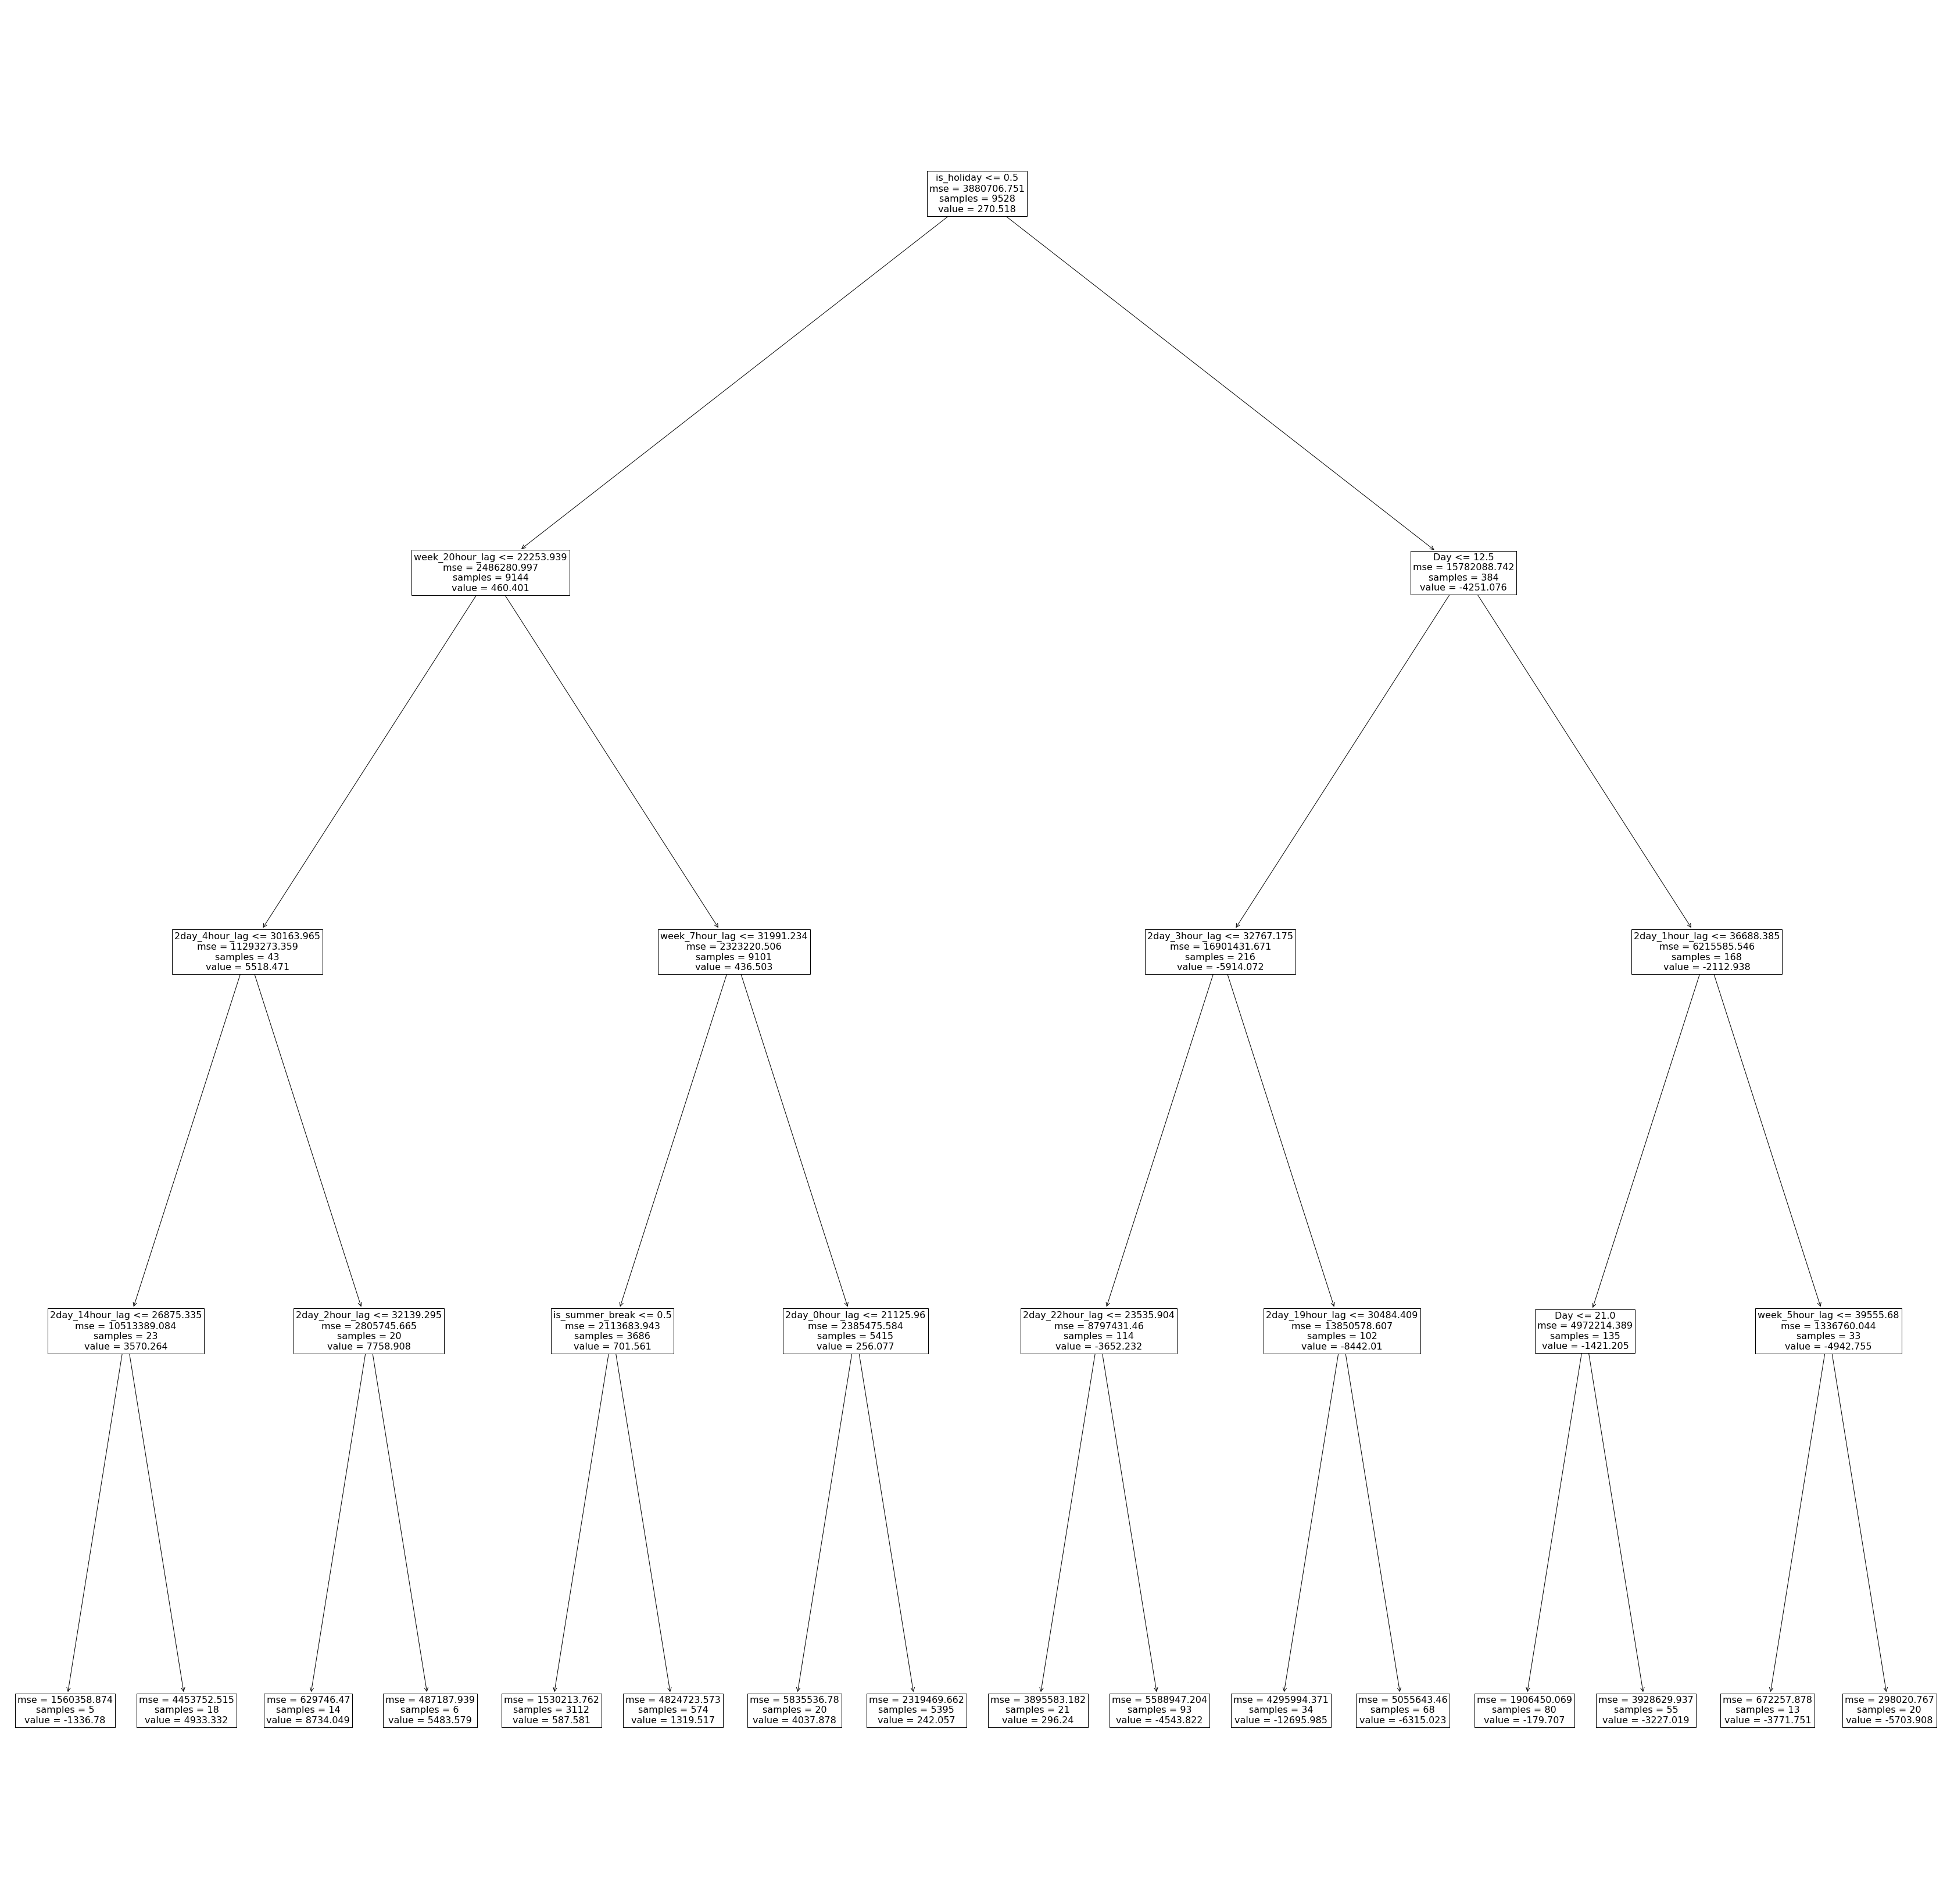

('Keras',
 1988.4382,
 0.062285724558912334,
 <tf.Tensor: shape=(), dtype=float32, numpy=1248.1774>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3.8238955>)

In [0]:
y_pred=model.predict(valid_df.drop(columns=["Date","Datetime","Consumption"])).reshape((1,-1))[0]
y_true=valid_df["Consumption"].values
eval_function("Keras",y_true,y_pred,valid_df.drop(columns=["Date","Consumption"]))